In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 

from sklearn.neighbors import DistanceMetric
from math import radians

from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import warnings 
warnings.simplefilter("ignore")

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

### Voici nos ensembles de données, leurs noms et les structures de relations entre eux. 

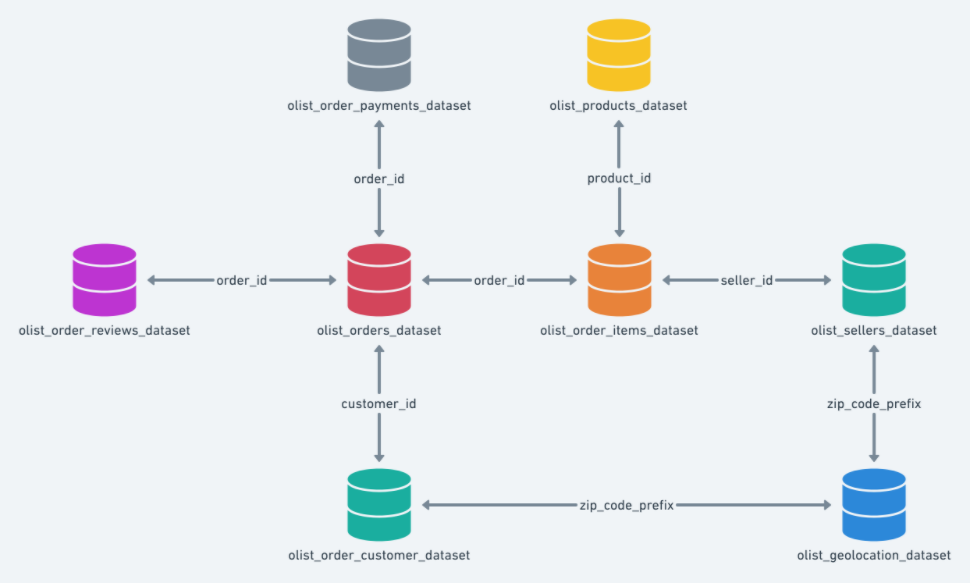

#### Chargement des données

In [2]:
Orders = pd.read_csv('data/olist_orders_dataset.csv')

Products = pd.read_csv('data//olist_products_dataset.csv')

Sellers = pd.read_csv('data//olist_sellers_dataset.csv')

Order_items = pd.read_csv('data//olist_order_items_dataset.csv')

Order_reviews =  pd.read_csv('data//olist_order_reviews_dataset.csv',dtype={'review_score':'int8'})

Order_payments = pd.read_csv('data//olist_order_payments_dataset.csv')

Customers = pd.read_csv('data//olist_customers_dataset.csv')

Product_category_name = pd.read_csv('data/product_category_name_translation.csv')

Geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')


#### Nous avons 9 ensembles de données à observer et les combiner tous ensemble pour une analyse plus approfondie

In [3]:
liste_df  = [Orders, Products, Sellers, Order_items,Order_reviews, Order_payments, Customers, Product_category_name,Geolocation ]

In [4]:
"""
Les types et quantités des colonnes par chaque dataset, 
ainsi que identification des clés internes et externes

"""

liste_noms = []
liste_colonnes = []
liste_types = []
liste_uniques = []

for df in liste_df:

    for column in df.columns:
        liste_noms.append(df)
        liste_colonnes.append(column)
        liste_types.append(df[column].dtype)
        liste_uniques.append(df[column].nunique())
        
    
resume_data = pd.DataFrame([liste_noms, 
                            liste_colonnes, 
                            liste_types, 
                            liste_uniques]
                          ).T
resume_data.columns=['Donnees', 'Nom colonne', 'Type', 'valeurs uniques']
resume_data

,Donnees,Nom colonne,Type,valeurs uniques
0,order_id ...,order_id,object,99441
1,order_id ...,customer_id,object,99441
2,order_id ...,order_status,object,8
3,order_id ...,order_purchase_timestamp,object,98875
4,order_id ...,order_approved_at,object,90733
5,order_id ...,order_delivered_carrier_date,object,81018
6,order_id ...,order_delivered_customer_date,object,95664
7,order_id ...,order_estimated_delivery_date,object,459
8,product_id ...,product_id,object,32951
9,product_id ...,product_category_name,object,73


In [5]:
new_df = pd.merge(Orders,Order_items,on='order_id')
new_df = new_df.merge(Order_payments,on ='order_id')
new_df = new_df.merge(Order_reviews,on ='order_id')
new_df = new_df.merge(Customers,on ='customer_id')
new_df = new_df.merge(Sellers,on ='seller_id')
new_df = new_df.merge(Products,on ='product_id')
new_df = new_df.merge(Product_category_name,on ='product_category_name')

In [6]:
# Identification des valeurs manquantes
taux_remplissage  = (new_df.isna().sum()).sort_values(ascending = False)
taux_remplissage

review_comment_title             102585
review_comment_message            66703
order_delivered_customer_date      2515
order_delivered_carrier_date       1213
order_approved_at                    14
product_height_cm                     1
product_length_cm                     1
product_weight_g                      1
product_width_cm                      1
product_category_name_english         0
shipping_limit_date                   0
payment_sequential                    0
freight_value                         0
price                                 0
order_estimated_delivery_date         0
seller_id                             0
product_id                            0
order_item_id                         0
payment_installments                  0
order_purchase_timestamp              0
order_status                          0
customer_id                           0
payment_type                          0
review_score                          0
payment_value                         0


In [7]:
df = new_df.copy()

In [8]:
# On va remplacer np.nan par 'No review' et 'No title' (pour éviter des problèmes plus tard)
df['review_comment_message'].fillna('No review',inplace=True)
df['review_comment_title'].fillna('No title',inplace=True)

In [9]:
# Identification des commandes non livrés 
customer_deliv_nan = df[df['order_delivered_customer_date'].isna()]

In [10]:
"""
Nous avons 'order_delivered_carrier_date == 1303',
c'est-à-dire avec des informations sur la non-réception 
des marchandises chez certains clients, il y a des informations 
sur la livraison de la réception des marchandises par la société de transport.

"""
customer_deliv_nan.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,2515,2131,fa65dad1b0e818e3ccc5cb0e39231352,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,2515,2131,9af2372a1e49340278e7c1ef8d749f34,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,2515,7,shipped,1225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp,2515,2130,2017-04-20 12:45:34,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_approved_at,2515,2123,2017-04-22 09:10:13,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_carrier_date,1303,1151,2017-04-24 11:31:17,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_customer_date,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_estimated_delivery_date,2515,386,2017-05-18 00:00:00,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,2515,NaN,NaN,NaN,1.17217,0.614221,1,1,1,1,6
product_id,2515,1821,1aecdb5fa3add74e385f25c6c527a462,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Processus de la préparation et de livraison des commandes 

* approved of receipt of the order  -> processing -> to be approved order delivery ->  shipped -> delivered -> invoiced

* approved of receipt of the order  -> processing -> unavailable (canceled)

* dans ce dataset pas de differance entre "approved of receipt of the order" et  "to be approved order delivery" 

In [11]:
customer_deliv_nan['order_status'].value_counts()

shipped        1225
canceled        546
invoiced        364
processing      362
delivered         8
unavailable       7
approved          3
Name: order_status, dtype: int64

In [12]:
# On peut obtenir la data de livraison pour 1959 clients
order_livre = customer_deliv_nan[customer_deliv_nan['order_status'].isin(['invoiced','processing','shipped','delivered'])]
order_livre.shape

(1959, 40)

In [13]:
# Récupération des données sur la colonne "order_delivered_carrier_date"
order_livre['order_delivered_carrier_date'].value_counts()

2017-04-24 11:31:17    29
2018-03-03 00:34:26     6
2017-04-06 14:00:15     6
2017-02-24 14:52:35     4
2017-06-20 15:32:01     4
                       ..
2017-12-06 20:18:15     1
2017-07-31 20:07:06     1
2017-04-10 09:34:30     1
2018-03-29 23:14:19     1
2017-10-04 17:39:53     1
Name: order_delivered_carrier_date, Length: 1085, dtype: int64

In [14]:
# Attribution 
df.loc[order_livre.index,'order_delivered_customer_date'] = df.loc[order_livre.index,'order_delivered_carrier_date']

In [15]:
# Vérification des résultats 
(df.isna().sum()).sort_values(ascending = False)

order_delivered_customer_date    1283
order_delivered_carrier_date     1213
order_approved_at                  14
product_height_cm                   1
product_length_cm                   1
product_weight_g                    1
product_width_cm                    1
product_category_name_english       0
seller_id                           0
payment_type                        0
payment_sequential                  0
freight_value                       0
price                               0
shipping_limit_date                 0
order_estimated_delivery_date       0
product_id                          0
order_item_id                       0
payment_value                       0
order_purchase_timestamp            0
order_status                        0
customer_id                         0
payment_installments                0
review_score                        0
review_id                           0
seller_zip_code_prefix              0
product_photos_qty                  0
product_desc

In [16]:
# Commandes non-livrées 
order_canceled = customer_deliv_nan[customer_deliv_nan['order_status'].isin(['canceled','unavailable'])]
len(order_canceled)

553

In [17]:
# Par exemple ( une commande avec la livraison plusieurs fois "cadences" )
df[df['customer_unique_id'] == '2592816433dfbb3051af91ba91625de5']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
6247,1057bf6391c17f9b6960dd996029e1dc,33b3ac58c257992bb9f0dff11643b8d0,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaN,NaN,2017-08-18 00:00:00,1,d274714b715480aa8ca7fca7d2524233,10ff823eda2b032e2c93d17a7d294736,2017-08-03 13:05:18,149.99,16.68,5,voucher,1,24.22,7e7b97a6b35356fff6395c6f29fa5310,1,No title,"Comprei o produto no site, porém depois de uns...",2017-08-20 00:00:00,2017-08-23 12:04:55,2592816433dfbb3051af91ba91625de5,5428,sao paulo,SP,17280,pederneiras,SP,utilidades_domesticas,53.0,484.0,2.0,1590.0,38.0,20.0,23.0,housewares
6248,1057bf6391c17f9b6960dd996029e1dc,33b3ac58c257992bb9f0dff11643b8d0,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaN,NaN,2017-08-18 00:00:00,1,d274714b715480aa8ca7fca7d2524233,10ff823eda2b032e2c93d17a7d294736,2017-08-03 13:05:18,149.99,16.68,8,voucher,1,9.46,7e7b97a6b35356fff6395c6f29fa5310,1,No title,"Comprei o produto no site, porém depois de uns...",2017-08-20 00:00:00,2017-08-23 12:04:55,2592816433dfbb3051af91ba91625de5,5428,sao paulo,SP,17280,pederneiras,SP,utilidades_domesticas,53.0,484.0,2.0,1590.0,38.0,20.0,23.0,housewares
6249,1057bf6391c17f9b6960dd996029e1dc,33b3ac58c257992bb9f0dff11643b8d0,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaN,NaN,2017-08-18 00:00:00,1,d274714b715480aa8ca7fca7d2524233,10ff823eda2b032e2c93d17a7d294736,2017-08-03 13:05:18,149.99,16.68,3,voucher,1,29.43,7e7b97a6b35356fff6395c6f29fa5310,1,No title,"Comprei o produto no site, porém depois de uns...",2017-08-20 00:00:00,2017-08-23 12:04:55,2592816433dfbb3051af91ba91625de5,5428,sao paulo,SP,17280,pederneiras,SP,utilidades_domesticas,53.0,484.0,2.0,1590.0,38.0,20.0,23.0,housewares
6250,1057bf6391c17f9b6960dd996029e1dc,33b3ac58c257992bb9f0dff11643b8d0,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaN,NaN,2017-08-18 00:00:00,1,d274714b715480aa8ca7fca7d2524233,10ff823eda2b032e2c93d17a7d294736,2017-08-03 13:05:18,149.99,16.68,4,voucher,1,33.46,7e7b97a6b35356fff6395c6f29fa5310,1,No title,"Comprei o produto no site, porém depois de uns...",2017-08-20 00:00:00,2017-08-23 12:04:55,2592816433dfbb3051af91ba91625de5,5428,sao paulo,SP,17280,pederneiras,SP,utilidades_domesticas,53.0,484.0,2.0,1590.0,38.0,20.0,23.0,housewares
6251,1057bf6391c17f9b6960dd996029e1dc,33b3ac58c257992bb9f0dff11643b8d0,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaN,NaN,2017-08-18 00:00:00,1,d274714b715480aa8ca7fca7d2524233,10ff823eda2b032e2c93d17a7d294736,2017-08-03 13:05:18,149.99,16.68,1,credit_card,1,0.33,7e7b97a6b35356fff6395c6f29fa5310,1,No title,"Comprei o produto no site, porém depois de uns...",2017-08-20 00:00:00,2017-08-23 12:04:55,2592816433dfbb3051af91ba91625de5,5428,sao paulo,SP,17280,pederneiras,SP,utilidades_domesticas,53.0,484.0,2.0,1590.0,38.0,20.0,23.0,housewares
6252,1057bf6391c17f9b6960dd996029e1dc,33b3ac58c257992bb9f0dff11643b8d0,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaN,NaN,2017-08-18 00:00:00,1,d274714b715480aa8ca7fca7d2524233,10ff823eda2b032e2c93d17a7d294736,2017-08-03 13:05:18,149.99,16.68,9,voucher,1,16.15,7e7b97a6b35356fff6395c6f29fa5310,1,No title,"Comprei o produto no site, porém depois de uns...",2017-08-20 00:00:00,2017-08-23 12:04:55,2592816433dfbb3051af91ba91625de5,5428,sao paulo,SP,17280,pederneiras,SP,utilidades_domesticas,53.0,484.0,2.0,1590.0,38.0,20.0,23.0,houseware

In [18]:
df.shape

(116581, 40)

In [19]:
# Suppression des commandes non livrées 
df = df[~df['order_status'].isin(['canceled','unavailable'])]

In [20]:
df.shape

(116021, 40)

In [21]:
# Vérification des résultats 
(df.isna().sum()).sort_values(ascending = False)

order_delivered_carrier_date     731
order_delivered_customer_date    730
order_approved_at                 14
product_height_cm                  1
product_length_cm                  1
product_weight_g                   1
product_width_cm                   1
product_category_name_english      0
seller_id                          0
payment_type                       0
payment_sequential                 0
freight_value                      0
price                              0
shipping_limit_date                0
order_estimated_delivery_date      0
product_id                         0
order_item_id                      0
payment_value                      0
order_purchase_timestamp           0
order_status                       0
customer_id                        0
payment_installments               0
review_score                       0
review_id                          0
seller_zip_code_prefix             0
product_photos_qty                 0
product_description_lenght         0
p

In [22]:
# Sur 730 lignes on a 597 commandes pour 597 clients 

df[df['order_delivered_customer_date'].isna()].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,730,597,f8a8d05d951ce7e359dfd0c67f1de017,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,730,597,b5a6e22f1c0652b0471c302536e40159,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,730,4,invoiced,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp,730,597,2017-11-30 10:04:05,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_approved_at,730,597,2017-11-30 10:22:16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_carrier_date,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_customer_date,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_estimated_delivery_date,730,282,2017-11-14 00:00:00,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,730,NaN,NaN,NaN,1.22603,0.678602,1,1,1,1,6
product_id,730,520,0a57f7d2c983bcf8188589a5fea4a8da,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Observons les pour comprendre comment récupérer les data de livraison chez les clients 
df[df['order_delivered_customer_date'].isna()][['order_id']].value_counts()

order_id                        
f8a8d05d951ce7e359dfd0c67f1de017    10
1b9c491d2bd15c21c2e2cfdda8769335     6
31dd19623d916b1848334732b797d5f5     6
83167649ca3fb63d1a7daada42232e14     5
93d8685fec4218f06bf202723dc1da52     5
0c87b31e37ed8557e234cec91546d4cc     5
df77e62df88949a20bf8bb2c2d9cb2ed     4
315f7759c3f6557f50e47798ccd673a3     4
35b8e54d765e6b217e2dc5ab34f6b323     4
fecc4ea5a3e06ce3192ae2f05b7a8439     4
bc50c4b649fb077defd8c5b6f1337468     4
a15be694d8267e907bfab3b785558e83     4
1c49e3fd28c9c369b12fd84446e475ab     4
8ed46f28f884bd76db1f8d95fc27a5f4     4
1a3ccc1695931b2cb7a95065e0c81e4b     4
0689012a897b2ac50b37994d77898bc8     3
b110523a5f9c69ad95bf8247062f0ba9     3
d1af798bd24f3f874cf16d2d2e02d981     3
3d521dbaec823d745bc7657d32442975     3
0e3e9e19e36c877fbd3decb94152e837     3
ca7d7c95b0f170aae8a2ee59e2f24f66     3
250eede6202cff2981de57cba5c1b08c     3
fc32248629afaea92d59f7086de552d3     3
ede510a059fd07ccec20bff19a227fa3     3
8d91588bf6ce83db4198f80c56776af

In [24]:
# Par exemple 
df[df['order_id'] =='f8a8d05d951ce7e359dfd0c67f1de017'].T

,35867,35868,35869,35870,35871,35872,35873,35874,35875,35876
order_id,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017,f8a8d05d951ce7e359dfd0c67f1de017
customer_id,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159,b5a6e22f1c0652b0471c302536e40159
order_status,processing,processing,processing,processing,processing,processing,processing,processing,processing,processing
order_purchase_timestamp,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05,2017-11-30 10:04:05
order_approved_at,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16,2017-11-30 10:22:16
order_delivered_carrier_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_customer_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_estimated_delivery_date,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00,2017-12-22 00:00:00
order_item_id,1,1,1,1,1,1,1,1,1,1
product_id,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42,2c5ae18918caa7b9adf593b80afb9b42


In [25]:
"""
Considérant que presque toutes les commandes sont en cours ou déjà facturé , 
donc on va attribuer les dates de "order_estimated_delivery_date"
"""
df[df['order_delivered_customer_date'].isna()][['order_status']].value_counts()

order_status
invoiced        364
processing      362
approved          3
delivered         1
dtype: int64

In [26]:
# Verification des valeurs np.nan dans la colonne 'order_estimated_delivery_date'
np.sum(df[df['order_delivered_customer_date'].isna()]['order_estimated_delivery_date'].isna() == False)

730

In [27]:
index_delivered_nan =df[df['order_delivered_customer_date'].isna()].index.values

In [28]:
# Attribution aux 2 colonnes les mêmes valeurs
df.loc[index_delivered_nan,'order_delivered_customer_date'] = df.loc[index_delivered_nan,'order_estimated_delivery_date']
df.loc[index_delivered_nan,'order_delivered_carrier_date'] = df.loc[index_delivered_nan,'order_estimated_delivery_date']


In [29]:
df.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      1
order_delivered_customer_date     0
order_estimated_delivery_date     0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
payment_sequential                0
payment_type                      0
payment_installments              0
payment_value                     0
review_id                         0
review_score                      0
review_comment_title              0
review_comment_message            0
review_creation_date              0
review_answer_timestamp           0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state              

In [30]:
# Suppression des lignes non renseignées
df.dropna(inplace=True)

In [31]:
df.shape

(116005, 40)

In [32]:
df_1 = df.copy()

In [33]:
# Pas de valeurs np.nan et dtypes: float64(10), int64(5), int8(1), object(24)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116005 entries, 0 to 116580
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116005 non-null  object 
 1   customer_id                    116005 non-null  object 
 2   order_status                   116005 non-null  object 
 3   order_purchase_timestamp       116005 non-null  object 
 4   order_approved_at              116005 non-null  object 
 5   order_delivered_carrier_date   116005 non-null  object 
 6   order_delivered_customer_date  116005 non-null  object 
 7   order_estimated_delivery_date  116005 non-null  object 
 8   order_item_id                  116005 non-null  int64  
 9   product_id                     116005 non-null  object 
 10  seller_id                      116005 non-null  object 
 11  shipping_limit_date            116005 non-null  object 
 12  price                         

In [34]:
# Toutes les colonnes contenant les dates
liste_data = ['order_purchase_timestamp','order_approved_at', 
                        'order_delivered_carrier_date','order_delivered_customer_date', 
                        'order_estimated_delivery_date','shipping_limit_date']

In [35]:
# Vérification du dernier jour de chaque colonne
df_1[liste_data].max()

order_purchase_timestamp         2018-09-03 09:06:57
order_approved_at                2018-09-03 17:40:06
order_delivered_carrier_date     2018-09-11 19:48:28
order_delivered_customer_date    2018-10-17 13:22:46
order_estimated_delivery_date    2018-10-25 00:00:00
shipping_limit_date              2020-04-09 22:35:08
dtype: object

In [36]:
# Identification des lignes correspondantes
data_limite = [x for x in df_1['shipping_limit_date'] if '2020' in x]
data_limite

['2020-04-09 22:35:08', '2020-04-09 22:35:08', '2020-02-03 20:23:22']

In [37]:
index_2020 = df_1[df_1['shipping_limit_date'].isin(data_limite)].index

In [38]:
# Suppression 
df_1.drop(index=index_2020, inplace=True)

In [39]:
# Prenons que les dates
for i in liste_data:
    df_1[i] = df_1[i].astype('datetime64')

In [40]:
# Vérification du dernier jour de chaque colonne
dernier_jour_actif = df_1[liste_data].max().max()
print('Dernier jour d\'activité {}'.format(dernier_jour_actif))
print(55*'-')
df_1[liste_data].max()

Dernier jour d'activité 2018-10-25 00:00:00
-------------------------------------------------------


order_purchase_timestamp        2018-09-03 09:06:57
order_approved_at               2018-09-03 17:40:06
order_delivered_carrier_date    2018-09-11 19:48:28
order_delivered_customer_date   2018-10-17 13:22:46
order_estimated_delivery_date   2018-10-25 00:00:00
shipping_limit_date             2018-09-18 21:10:15
dtype: datetime64[ns]

In [41]:
dernier_jour_actif

Timestamp('2018-10-25 00:00:00')

In [42]:
df_2 = df_1.copy()

In [43]:
# Déterminons le nombre de commandes pour chaque client
commandes_par_client = df_2.groupby('order_id').size().reset_index()
commandes_par_client.rename(columns={0:'order_number'}, inplace = True)
commandes_par_client['order_number'].value_counts()


1     84119
2      9644
3      1523
4       813
6       277
5       235
7        46
8        39
12       20
10       15
9        11
11       11
15        6
24        5
14        5
13        3
20        3
21        3
16        2
22        2
38        1
19        1
26        1
29        1
63        1
Name: order_number, dtype: int64

In [44]:
# On a un client avec 63 commandes ??
commandes_par_client[commandes_par_client['order_number'] == 63]

,order_id,order_number
51738,895ab968e7bb0d5659d16cd74cd1650c,63


In [45]:
# Un seul produit, commandé et livré une seule fois, mais enregistrée en 63 commandes différentes 
df_2[df_2['order_id'] == '895ab968e7bb0d5659d16cd74cd1650c'][['product_id','order_purchase_timestamp','order_delivered_customer_date']]

,product_id,order_purchase_timestamp,order_delivered_customer_date
6409,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6410,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6411,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6412,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6413,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6414,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6415,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6416,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6417,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18
6418,5ddab10d5e0a23acb99acf56b62b3276,2017-08-08 20:26:31,2017-08-14 12:46:18


In [46]:
# Intégrons les quantités de commandes dans le dataset
df_2 = pd.merge(commandes_par_client,df_2,how = 'inner',on='order_id')

In [47]:
df_2.shape

(116002, 41)

In [48]:
df_2.drop_duplicates ('order_id', keep = 'first', inplace = True)

In [49]:
df_2.shape

(96787, 41)

In [50]:
# Vérification des résultats 
print(df_2.groupby('order_id')['order_item_id'].agg('count').value_counts())
df_2.drop(columns='order_id', inplace=True)

1    96787
Name: order_item_id, dtype: int64


In [51]:
df_2.groupby('order_number')['order_item_id'].size()

order_number
1     84119
2      9644
3      1523
4       813
5       235
6       277
7        46
8        39
9        11
10       15
11       11
12       20
13        3
14        5
15        6
16        2
19        1
20        3
21        3
22        2
24        5
26        1
29        1
38        1
63        1
Name: order_item_id, dtype: int64

In [52]:
# Creation d'une nouvelle colonne affichant la duree d'inactivité des clients
df_2['client_inactif'] = dernier_jour_actif-df_2['order_purchase_timestamp']

In [53]:
df_2['client_inactif']

0        406 days 15:00:58
1        546 days 13:06:54
2        283 days 09:26:29
3         77 days 13:59:25
4        627 days 10:02:09
                ...       
115997   184 days 10:02:54
115998   102 days 13:33:14
115999   366 days 06:52:04
116000   436 days 00:57:01
116001   137 days 06:59:42
Name: client_inactif, Length: 96787, dtype: timedelta64[ns]

In [54]:
# Apparemment , le client avec une identification unique n'est pas unique (il était créé avec chaque nouvelle commande )
df_2[df_2.duplicated('customer_unique_id')]['customer_unique_id']

2505      b5b46581465f851df3529a30d2503f59
2969      d0813c57df04369487ff42ab24dd0ac7
5233      ab744045d2445f5bae53b57a4b99bfbf
5346      065dcef61d5f66b30d2ee51b5343d023
5595      a914b2be4782207abc6758095ec9e8aa
                        ...               
115859    acc4424c209233de519e034152f30304
115875    c130bf40aa6d3bdb444b04a8d78adf5a
115953    71d2dbb6d2f52d568ca9d69c815a4331
115971    4e15fee963523774998876e3624952f4
115982    2b19910e856b2ba3e7257e63a093a3df
Name: customer_unique_id, Length: 3138, dtype: object

In [55]:
# Par exemple 
df_2[df_2['customer_unique_id'] == 'b5b46581465f851df3529a30d2503f59']

,order_number,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,client_inactif
433,2,8eafffbc006c6986450ed2a5e6f519c5,delivered,2017-09-26 14:49:01,2017-09-26 17:07:16,2017-10-04 08:33:14,2017-10-09 15:15:38,2017-10-24,1,1491a8ff192d4b5c369b0eaa2fe33ee5,37be5a7c751166fbc5f8ccba4119e043,2017-10-03 17:07:16,179.99,26.10,1,credit_card,8,412.18,2d1188a2d2ee61107412d6f175d8733d,5,No title,Lindo,2017-10-10 00:00:00,2017-10-10 19:05:50,b5b46581465f851df3529a30d2503f59,28470,santo antonio de padua,RJ,4248,sao paulo,SP,cama_mesa_banho,46.0,162.0,5.0,4600.0,60.0,19.0,50.0,bed_bath_table,393 days 09:10:59
2505,2,f0adbcc906e94774e167ee43ce2209f2,delivered,2017-10-03 23:52:07,2017-10-04 22:28:23,2017-10-06 19:53:18,2017-10-16 16:08:07,2017-11-01,1,b791d5d05f0c974d148d358efcd21d84,7aa4334be125fcdd2ba64b3180029f14,2017-10-10 22:28:23,25.99,16.11,1,credit_card,5,84.20,184daa25c193922889fb2360d9be6005,5,No title,Amei,2017-10-17 00:00:00,2017-10-17 19:36:58,b5b46581465f851df3529a30d2503f59,28470,santo antonio de padua,RJ,18500,laranjal paulista,SP,cama_mesa_banho,59.0,1092.0,1.0,500.0,16.0,20.0,16.0,bed_bath_table,386 days 00:07:53


In [56]:
# Recuperation de la dernieredate d'activité 
client_inactif = df_2.groupby('customer_unique_id')['client_inactif'].agg('min').reset_index()
client_inactif.rename(columns ={'client_inactif':'client_inactif_jour'}, inplace = True)
client_inactif

,customer_unique_id,client_inactif_jour
0,0000366f3b9a7992bf8c76cfdf3221e2,167 days 13:03:33
1,0000b849f77a49e4a4ce2b2a4ca5be3f,170 days 12:48:33
2,0000f46a3911fa3c0805444483337064,593 days 02:54:57
3,0000f6ccb0745a6a4b88665a16c9f078,377 days 03:30:19
4,0004aac84e0df4da2b147fca70cf8255,344 days 04:14:18
...,...,...
93644,fffcf5a5ff07b0908bd4e2dbc735a684,503 days 02:59:24
93645,fffea47cd6d3cc0a88bd621562a9d061,318 days 03:52:04
93646,ffff371b4d645b6ecea244b27531430a,624 days 08:10:44
93647,ffff5962728ec6157033ef9805bacc48,175 days 08:42:19


In [57]:
# Insertion dans le dataset
df_2 = pd.merge(df_2,client_inactif,on = 'customer_unique_id')

In [58]:
# Vérification de résultat 
df_2[df_2['customer_unique_id'] == 'b5b46581465f851df3529a30d2503f59'][['client_inactif','client_inactif_jour']]

,client_inactif,client_inactif_jour
393,393 days 09:10:59,386 days 00:07:53
394,386 days 00:07:53,386 days 00:07:53


In [59]:
# Suppression 
df_2.drop(columns='client_inactif', inplace=True)

In [60]:
# Delai de livraison  
df_2['delai_livraison'] = df_2['order_delivered_customer_date']-df_2['order_purchase_timestamp']
df_2['delai_livraison']

0        7 days 14:44:46
1       16 days 05:11:18
2        7 days 05:47:42
3        7 days 22:45:45
4        6 days 03:32:04
              ...       
96782   17 days 08:59:34
96783    9 days 10:05:09
96784    4 days 19:14:26
96785    1 days 22:56:41
96786    5 days 00:56:08
Name: delai_livraison, Length: 96787, dtype: timedelta64[ns]

In [61]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96787 entries, 0 to 96786
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_number                   96787 non-null  int64          
 1   customer_id                    96787 non-null  object         
 2   order_status                   96787 non-null  object         
 3   order_purchase_timestamp       96787 non-null  datetime64[ns] 
 4   order_approved_at              96787 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   96787 non-null  datetime64[ns] 
 6   order_delivered_customer_date  96787 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  96787 non-null  datetime64[ns] 
 8   order_item_id                  96787 non-null  int64          
 9   product_id                     96787 non-null  object         
 10  seller_id                      96787 non-null  object         
 11  sh

In [62]:
df_3 = df_2.copy()

In [63]:
# On va garder la traduction
df_3[['product_category_name_english', 'product_category_name']][-5:]

,product_category_name_english,product_category_name
96782,housewares,utilidades_domesticas
96783,computers_accessories,informatica_acessorios
96784,sports_leisure,esporte_lazer
96785,computers_accessories,informatica_acessorios
96786,bed_bath_table,cama_mesa_banho


In [64]:
df_3.drop(columns='product_category_name', inplace=True)

In [65]:
# Creation des catégories 

dict_categories = {
#home
'furniture_living_room' : 'home',
'furniture_mattress_and_upholstery' : 'home',
'furniture_bedroom' : 'home',
'furniture_decor' : 'home',
'bed_bath_table' : 'home',
'kitchen_dining_laundry_garden_furniture' : 'home',
'la_cuisine' : 'home',
'home_confort' : 'home',
'home_comfort_2' : 'home',
'christmas_supplies' : 'home',
    
#appliances
'small_appliances' : 'appliances',
'small_appliances_home_oven_and_coffee' : 'appliances',
'home_appliances_2' : 'appliances',
'home_appliances' : 'appliances',
'housewares' : 'appliances',
#construction
'construction_tools_construction': 'construction',
'costruction_tools_garden': 'construction',
'costruction_tools_tools': 'construction',
'construction_tools_safety': 'construction',
'construction_tools_lights': 'construction',
'home_construction': 'construction',
'air_conditioning': 'construction',
#furnitures
    
#office
'office_furniture' : 'office',
'industry_commerce_and_business' : 'office',
'stationery' : 'office',
'agro_industry_and_commerce' : 'office',
'signaling_and_security' : 'office',
'furnitures' : 'office',
'security_and_services' : 'office',
#electronics
'telephony' : 'electronics',
'electronics': 'electronics',
'computers_accessories': 'electronics',
'consoles_games': 'electronics',
'fixed_telephony': 'electronics',
'audio': 'electronics',
'computers': 'electronics',
'tablets_printing_image': 'electronics',
#sports_leisure
'sports_leisure' : 'sports_leisure',
'musical_instruments': 'sports_leisure',
'party_supplies': 'sports_leisure',
'luggage_accessories': 'sports_leisure',
#arts
'books' : 'arts',
'books_imported': 'arts',
'books_general_interest': 'arts',
'books_technical': 'arts',
'art': 'arts',
'toys': 'arts',
'cine_photo': 'arts',
'cds_dvds_musicals': 'arts',
'music': 'arts',
'dvds_blu_ray': 'arts',
'arts_and_craftmanship': 'arts',
#fashion
'watches_gifts' : 'fashion',
'fashion_bags_accessories' : 'fashion',
'fashion_underwear_beach' : 'fashion',
'fashion_shoes' : 'fashion', 
'fashion_male_clothing' : 'fashion',
'fashio_female_clothing' : 'fashion',
'fashion_sport' : 'fashion',
'fashion_childrens_clothes' : 'fashion',
 #health_beauty
'health_beauty' : 'health_beauty', 
'baby': 'health_beauty',
'diapers_and_hygiene' : 'health_beauty',
'perfumery' : 'health_beauty',
#garden and pets
'flowers' : 'garden_pets',
'pet_shop' : 'garden_pets',
'garden_tools' : 'garden_pets',
#auto
'auto' : 'auto',
#food_drinks
'food_drink' : 'food_drinks',
'food' : 'food_drinks',
'drinks' : 'food_drinks',
#other
'market_place' : 'other', 
'cool_stuff' : 'other'} 

In [66]:
# Attribution de nouvelles valeurs
df_3['product_category_name_english']=df_3['product_category_name_english'].map(dict_categories)

In [67]:
df_3['product_category_name_english'].sample(5)

81562           fashion
59162     health_beauty
47869     health_beauty
46162       garden_pets
49414    sports_leisure
Name: product_category_name_english, dtype: object

# 

In [68]:
# Moyen de paiement 

df_3['payment_type'].value_counts() 

credit_card    73457
boleto         19256
voucher         2590
debit_card      1484
Name: payment_type, dtype: int64

In [69]:
# Creation de nouvelle colonne " la durée de réponse au client "
df_3['review_creation_date'] = pd.to_datetime(df_3['review_creation_date']).dt.date
df_3['review_answer_timestamp'] = pd.to_datetime(df_3['review_answer_timestamp']).dt.date
df_3['reponse_au_client'] = df_3['review_answer_timestamp']-df_3['review_creation_date']
df_3['reponse_au_client'] = df_3['reponse_au_client']/np.timedelta64(1,'D')

In [70]:
# Suppression 
df_3.drop(columns=['review_id', 'review_comment_title','review_comment_message', 
                   'review_creation_date','review_answer_timestamp'], inplace=True)

In [71]:
# La fonction qui supprime (transforme) des valeurs négatives et égale à zero

def nomb_neg_zero(num):
    if num <= 0:
        return 1
    else:
        return num

In [72]:
df_3['reponse_au_client'].astype(int)
df_3['reponse_au_client'] = [nomb_neg_zero(x) for x in df_3['reponse_au_client']] 

In [73]:
df_3['review_score'].value_counts()   

5    56230
4    18767
1    10662
3     8053
2     3075
Name: review_score, dtype: int64

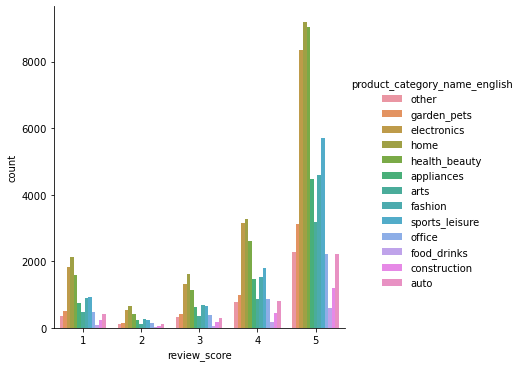

In [74]:
# Le score par produit
sns.catplot('review_score',data=df_3, kind='count' ,hue = 'product_category_name_english')
plt.savefig('images/score_produit.png')

# 

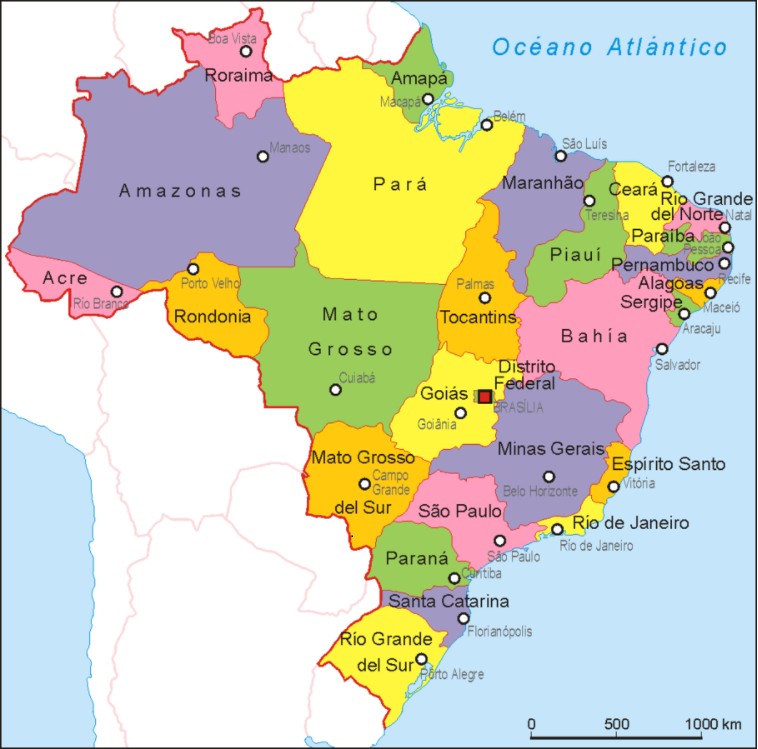

In [75]:
# Pourcentage de clients par ville
(df_3['customer_city'].value_counts()/df_3['customer_city'].shape[0]).head(40)

sao paulo                0.155455
rio de janeiro           0.069121
belo horizonte           0.027772
brasilia                 0.021490
curitiba                 0.015364
campinas                 0.014537
porto alegre             0.013938
salvador                 0.012553
guarulhos                0.011892
sao bernardo do campo    0.009330
niteroi                  0.008596
santo andre              0.008059
osasco                   0.007553
santos                   0.007222
sao jose dos campos      0.006943
goiania                  0.006829
fortaleza                0.006602
sorocaba                 0.006344
recife                   0.006220
florianopolis            0.005703
jundiai                  0.005621
ribeirao preto           0.005197
nova iguacu              0.004484
belem                    0.004453
barueri                  0.004329
juiz de fora             0.004319
contagem                 0.004246
sao goncalo              0.004122
mogi das cruzes          0.003885
vitoria       

In [76]:
# Vérification des valeurs 
Geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [77]:
# La quantité de 'geolocation_zip_code_prefix'
print("La quantité total de geolocation_zip_code_prefix: ",len(Geolocation['geolocation_zip_code_prefix']))
print("La quantité unique de geolocation_zip_code_prefix: ",len(Geolocation['geolocation_zip_code_prefix'].value_counts()))

La quantité total de geolocation_zip_code_prefix:  1000163
La quantité unique de geolocation_zip_code_prefix:  19015


In [78]:
# La quantité de 'customer_zip_code_prefix'
len(df_3['customer_zip_code_prefix'].value_counts())

14914

In [79]:
# ZIP codes de nos clients 
commun_zip_code = set(df_3['customer_zip_code_prefix'].values).intersection(Geolocation['geolocation_zip_code_prefix'].values)
len(commun_zip_code)

14763

In [80]:
# Choisissons uniquement les codes postaux intéressants pour notre analyse 
Geolocation = Geolocation[Geolocation['geolocation_zip_code_prefix'].isin(commun_zip_code)]
Geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [81]:
Geolocation.shape

(967259, 5)

In [82]:
# On va combiner les 2 datasets
geolocal = pd.merge(df_3, Geolocation, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

In [83]:
geolocal.shape

(14685269, 42)

In [84]:
# On va se basé sur latitude et longitude 
lat_lng = geolocal.groupby('customer_unique_id')[['geolocation_lng','geolocation_lat']].mean().reset_index()
lat_lng.sample(5)

,customer_unique_id,geolocation_lng,geolocation_lat
15957,2b7b58bdb468abea0076f15e37e3d470,-42.368145,-21.130016
36418,633298c0361135a8a3d520ccbc17d2c3,-46.686851,-23.544037
90690,f7ba21d6b0af7a0cb8f9291a1d8e81a3,-42.416865,-22.159688
72656,c65e4c1159907cd349e6b6e6c2fec285,-50.668082,-22.615059
29167,4f703d6eae4d281cc09a785b51c49344,-43.383956,-21.786428


In [85]:
lat_lng.shape

(93649, 3)

In [86]:
# On fusionne ces 2 datasets
df_3 =pd.merge(df_3,lat_lng,on='customer_unique_id')

In [87]:
df_3.isna().sum()

order_number                       0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
order_item_id                      0
product_id                         0
seller_id                          0
shipping_limit_date                0
price                              0
freight_value                      0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_score                       0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
seller_zip_code_prefix             0
seller_city                        0
seller_state                       0
product_name_lenght                0
p

In [88]:
df_3.dropna(inplace=True)

In [89]:
df_3.shape

(96523, 39)

In [90]:
# La ville et ses coordonnées géographiques 
ville_lat_lng = df_3[['customer_city','geolocation_lat','geolocation_lng']]
ville_lat_lng.sample(3)

,customer_city,geolocation_lat,geolocation_lng
27213,tijucas,-27.239249,-48.637067
54197,taubate,-23.027830,-45.620991
4996,santos,-23.972316,-46.314414


In [91]:
ville_lat_lng.shape

(96523, 3)

In [92]:
# Regroupement des villes 
ville_client = ville_lat_lng.groupby(by='customer_city')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
ville_client.shape

(4050, 3)

In [93]:
# Convertir en radian
ville_client['lat'] = np.radians(ville_client['geolocation_lat'])
ville_client['lng'] = np.radians(ville_client['geolocation_lng'])

In [94]:
# Calcul la distance entre les villes
metric_distance = DistanceMetric.get_metric('haversine')

In [95]:
ville_client[['lat','lng']].to_numpy()

array([[-0.32244044, -0.82742284],
       [-0.28263412, -0.85014152],
       [-0.33437378, -0.79318757],
       ...,
       [-0.36739934, -0.87358488],
       [-0.05718196, -0.79682842],
       [-0.47919372, -0.89974725]])

In [96]:
# Distance entre les villes en km (pour transformation il faut *6373)
distance = pd.DataFrame(metric_distance.pairwise(ville_client[['lat','lng']].to_numpy())*6373,  columns=ville_client.customer_city.unique(), index=ville_client.customer_city.unique())
distance

abadia dos dourados    abadiania       abaete  \
abadia dos dourados             0.000000   288.886193   220.076464   
abadiania                     288.886193     0.000000   477.794900   
abaete                        220.076464   477.794900     0.000000   
abaetetuba                   1870.178009  1609.685296  1975.068612   
abaiara                      1532.199388  1438.928539  1483.524806   
...                                  ...          ...          ...   
xinguara                     1295.380388  1021.286127  1427.087620   
xique-xique                   988.693089   880.377676   971.933312   
zacarias                      398.408615   558.439654   525.130210   
ze doca                      1701.231387  1475.138726  1766.689060   
zortea                       1085.129791  1286.432506  1113.410872   

                      abaetetuba      abaiara       abaira        abare  \
abadia dos dourados  1870.178009  1532.199388   845.556623  1405.970480   
abadiania            1609.685296  1438.928539   825.509411  1330.611557   
abaete               1975.068612  1483.524806   771.242063  1346.835429   
abaetetuba              0.000000  1257.443851  1508.408114  1326.882308   
abaiara              1257.443851     0.000000   715.238515   149.268525   
...                          ...          ...          ...          ...   
xinguara              608.071770  1201.035050  1134.511070  1200.047856   
xique-xique          1219.238838   558.551018   293.710679   457.458779   
zacarias             2153.536754  1928.689808  1243.352781  1803.905181   
ze doca               397.952363   861.210141  1193.037336   938.039232   
zortea               2876.358116  2595.163132  1884.613383  2459.942659   

                          abatia  abdon batista  abelardo luz     abrantes  \
abadia dos dourados   616.092014    1081.152802   1019.999587  1162.767492   
abadiania             808.472977    1291.876867   1198.606746  1185.013304   
abaete                683.306501    1098.610143   1074.876304  1041.293523   
abaetetuba           2405.454575    2888.309064   2771.958541  1701.062162   
abaiara              2143.455789    2581.913464   2545.885531   614.565902   
...                          ...            ...           ...          ...   
xinguara             1804.057323    2285.289976   2165.336368  1427.678774   
xique-xique          1604.440346    2058.600686   2008.338807   534.566570   
zacarias              252.128986     736.100630    641.938418  1550.914597   
ze doca              2283.378310    2765.947041   2671.754310  1337.880954   
zortea                478.270417      54.680441    141.372413  2134.484253   

                      abre campo  abreu e lima      acaiaca   acailandia  \
abadia dos dourados   555.829931   1790.105830   494.114967  1504.800593   
abadiania             801.049839   1759.443005   748.564258  1258.216614   
abaete                335.900830   1690.222480   275.742775  1596.210549   
abaetetuba           2179.822166   1693.647820  2164.951352   390.580430   
abaiara              1485.509839    459.772613  1512.365383   970.957292   
...                          ...           ...          ...          ...   
xinguara             1674.090594   1658.134569  1647.430766   360.323500   
xique-xique          1053.796379    916.519681  1062.018415   837.776212   
zacarias              793.125982   2186.035581   722.810156  1812.633392   
ze doca              1924.080251   1295.837562  1919.938133   275.115373   
zortea               1218.617454   2791.518670  1162.599815  2540.573358   

                       acajutiba       acarau        acari       acegua  \
abadia dos dourados  1260.221641  1906.973748  1776.147914  1625.572032   
abadiania            1258.451337  1753.537570  1704.646327  1817.153311   
abaete               1152.064804  1900.263950  1705.970592  1650.580662   
abaetetuba           1630.121848   983.316698  1455.378248  3386.900417   
abaiara               491.813770   510.781426   284.73

In [97]:
# Distances de toute les villes de 'Sao paulo' ('Sao paulo' -- ville avec le plus de clients)
dict_distance = {distance.index.values[i] : np.round(distance['sao paulo'][i],1) for i in range(distance.shape[0])}
dict_distance

{'abadia dos dourados': 572.5,
 'abadiania': 848.7,
 'abaete': 505.9,
 'abaetetuba': 2442.1,
 'abaiara': 1976.8,
 'abaira': 1261.6,
 'abare': 1836.0,
 'abatia': 376.5,
 'abdon batista': 629.1,
 'abelardo luz': 659.6,
 'abrantes': 1485.2,
 'abre campo': 562.9,
 'abreu e lima': 2143.5,
 'acaiaca': 506.7,
 'acailandia': 2073.6,
 'acajutiba': 1607.1,
 'acarau': 2404.9,
 'acari': 2185.0,
 'acegua': 1173.5,
 'acopiara': 2090.4,
 'acreuna': 789.3,
 'acu': 2255.7,
 'acucena': 645.7,
 'adamantina': 502.1,
 'adhemar de barros': 630.1,
 'adolfo': 404.1,
 'adrianopolis': 267.6,
 'adustina': 1708.1,
 'afogados da ingazeira': 2007.3,
 'afonso claudio': 688.8,
 'afranio': 1776.8,
 'agisse': 195.0,
 'agrolandia': 534.1,
 'agronomica': 514.6,
 'agua boa': 1208.9,
 'agua branca': 1964.2,
 'agua clara': 731.9,
 'agua comprida': 419.3,
 'agua doce': 624.7,
 'agua doce do norte': 809.9,
 'agua fria de goias': 963.7,
 'agua limpa': 649.9,
 'agua nova': 2127.7,
 'agua preta': 2033.2,
 'agua santa': 745.5,
 '

In [98]:
# Attribution 
df_3['customer_city'] = df_3['customer_city'].map(dict_distance)
df_3['customer_city'].sample(5)

47641    1461.5
20743    2463.6
40914      97.0
86449     272.9
39955     595.0
Name: customer_city, dtype: float64

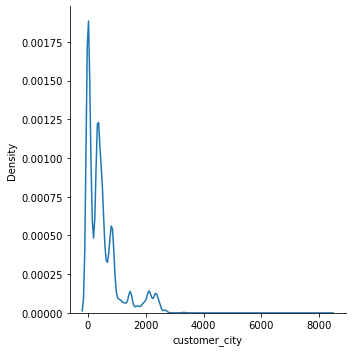

In [99]:
sns.displot(df_3['customer_city'], kind="kde")
plt.savefig('images/localisation des clients.png')

In [100]:
df_3.drop(columns=['geolocation_lng','geolocation_lat'],inplace=True)

In [101]:
df_4 = df_3.copy()

In [102]:
"""
* Transformer les variables dtype == 'objet' en int ou float(StandardScaler, OneHotEncoder,...soit supprimer)
* Features ingenering avec les variables numeriques (si nécessaire)
"""
variables_categorielles  = [col for col, dtype in zip(df_4.columns,df_4.dtypes)
                            if dtype =='object' and col not in ['customer_unique_id']]
variables_numeriques = [col for col, dtype in zip(df.columns, df.dtypes) 
                       if dtype.kind in ['i','f']]

In [103]:
print(100*'-')
print('variables_catégorielles :\n\n' + str(variables_categorielles))
print(100*'-')
print("variables_categorielles == ",len(variables_categorielles))
print(100*'-')
print('variables_numeriques :\n\n' + str(variables_numeriques))
print(100*'-')
print("variables_numeriques == ",len(variables_numeriques))

----------------------------------------------------------------------------------------------------
variables_catégorielles :

['customer_id', 'order_status', 'product_id', 'seller_id', 'payment_type', 'customer_state', 'seller_city', 'seller_state', 'product_category_name_english']
----------------------------------------------------------------------------------------------------
variables_categorielles ==  9
----------------------------------------------------------------------------------------------------
variables_numeriques :

['order_item_id', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'review_score', 'customer_zip_code_prefix', 'seller_zip_code_prefix', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
----------------------------------------------------------------------------------------------------
variables_numeriques == 

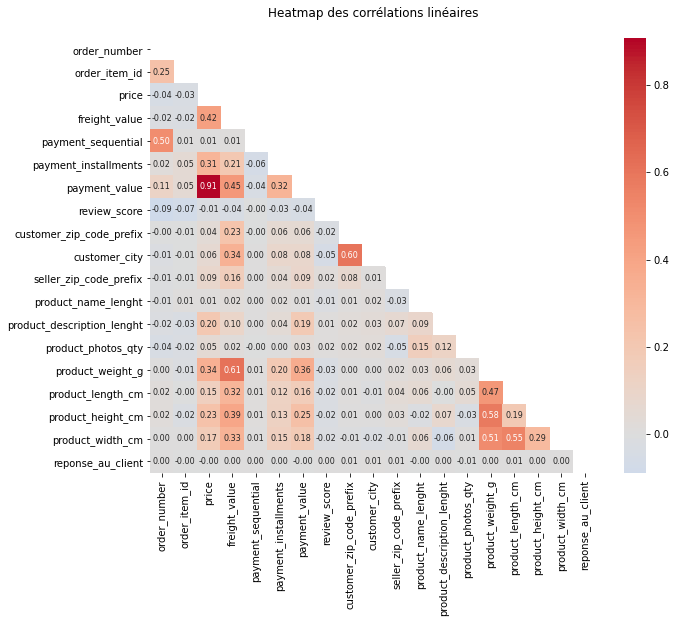

<Figure size 432x288 with 0 Axes>

In [104]:
corr = df_4.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", )
plt.show()
plt.savefig('images/Heatmap des corrélations.png') 

In [105]:
threshold = 0.5
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
12,price,payment_value,0.907310
10,freight_value,product_weight_g,0.614791
8,customer_zip_code_prefix,customer_city,0.601143
6,product_height_cm,product_weight_g,0.580702
4,product_length_cm,product_width_cm,0.547977
2,product_width_cm,product_weight_g,0.512909
0,payment_sequential,order_number,0.503553


In [106]:
df_4[['client_inactif_jour','delai_livraison']] = (df_4[['client_inactif_jour','delai_livraison']]/np.timedelta64(1,'D')).astype(int)
df_4[['client_inactif_jour','delai_livraison']]

,client_inactif_jour,delai_livraison
0,406,7
1,401,16
2,401,7
3,283,7
4,77,6
...,...,...
96782,184,17
96783,102,9
96784,366,4
96785,436,1


order_number 0.56
payment_value 46962.14
payment_sequential 0.06
payment_installments 7.36


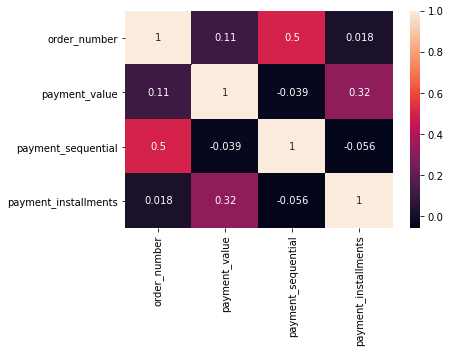

In [107]:
# La corrélation  entre ces variables 
for i in df_4[['order_number','payment_value','payment_sequential','payment_installments']]:
    print(i,np.round(np.var(df_4[i]),2))
sns.heatmap(df_4[['order_number','payment_value','payment_sequential','payment_installments']].corr(),annot=True)
plt.savefig('images/orrélations_order_money_instal.png') 

In [108]:
df_4.drop(columns='payment_sequential',inplace=True)

In [109]:
# Combinons ces 3 variables 
df_4['dimension_m3'] = ((df_4['product_height_cm']*df_4['product_length_cm']*df_4['product_width_cm'])/1000)

In [110]:
df_4.drop(columns=['product_height_cm','product_length_cm','product_width_cm'], inplace=True)

In [111]:
# Correlation fort 
df_4_poids_dim = df_4[['customer_city','freight_value','dimension_m3','product_weight_g']]

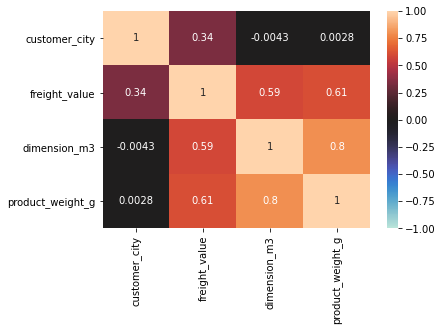

In [112]:
sns.heatmap(df_4_poids_dim.corr(),vmax=1,vmin=-1,annot=True,center=0.0)
plt.savefig('images/city_taille_poids_FDP.png')

In [113]:
df_5=df_4.copy()

In [114]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96523 entries, 0 to 96786
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_number                   96523 non-null  int64         
 1   customer_id                    96523 non-null  object        
 2   order_status                   96523 non-null  object        
 3   order_purchase_timestamp       96523 non-null  datetime64[ns]
 4   order_approved_at              96523 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96523 non-null  datetime64[ns]
 6   order_delivered_customer_date  96523 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96523 non-null  datetime64[ns]
 8   order_item_id                  96523 non-null  int64         
 9   product_id                     96523 non-null  object        
 10  seller_id                      96523 non-null  object        
 11  shipping_limit_

# 

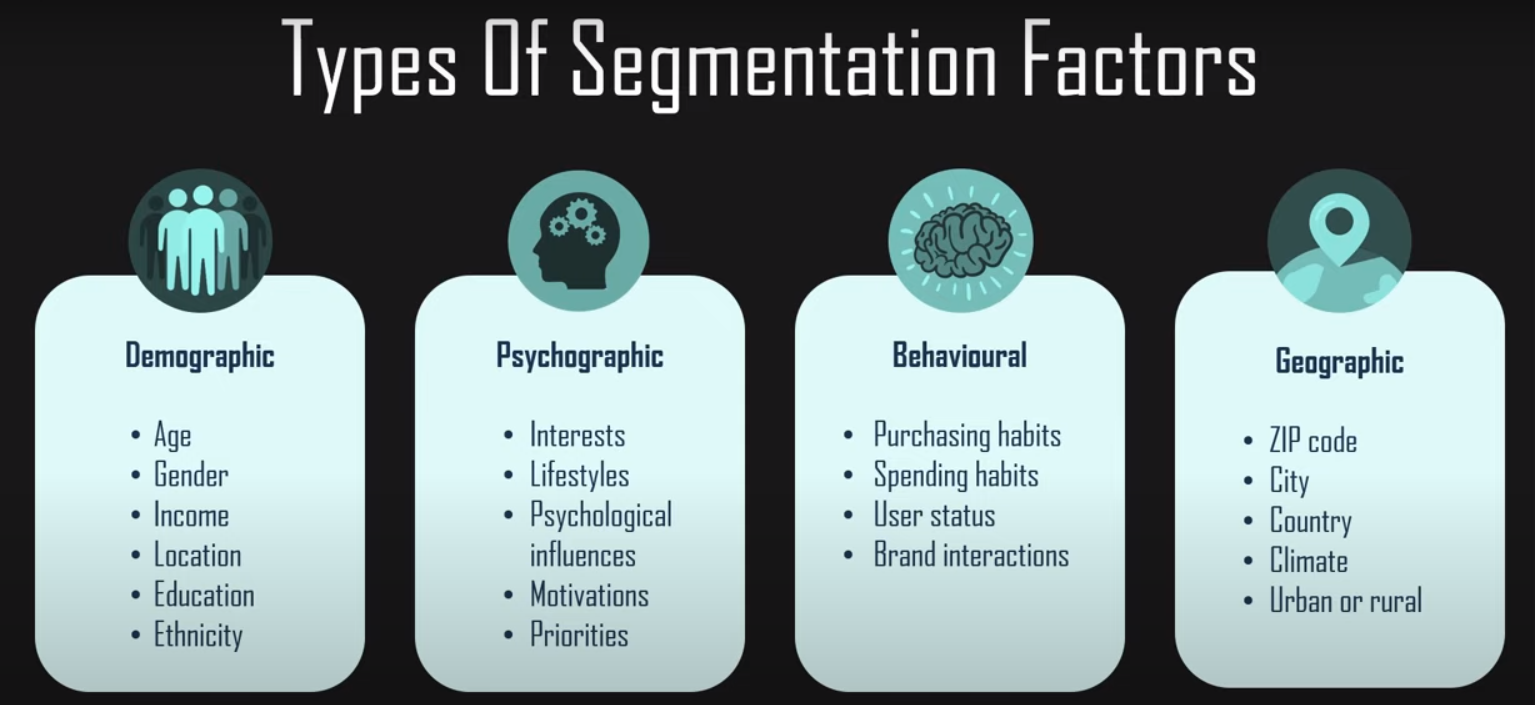

# RFM Modeling

### Modélisation RFM pour chaque client (pas d'âge, de sexe, de revenu, d'éducation...)

### Creation standard du model de RFM

In [115]:
dernier_jour_actif = df_1[liste_data].max().max()

In [116]:
Recency= df_5.groupby(by='customer_unique_id')['order_purchase_timestamp'].\
agg( lambda x: (dernier_jour_actif-x.max()).days).reset_index()

In [117]:
Frequency = df_5.groupby(by='customer_unique_id')['order_number'].agg('sum').reset_index()

In [118]:
Monetary = df_5.groupby('customer_unique_id')['payment_value'].agg('mean').reset_index()

In [119]:
RFMScores = pd.merge(Recency,pd.merge(Frequency,Monetary ))

#### Les variables que nous venons de créer étaient déjà dans notre ensemble de données. Donc ça sera inutile de les rajouter dans notre dataset

In [120]:
# Vérification de leur coïncidence
identique = RFMScores.sample(5)['customer_unique_id'].values
identique

array(['882a0176c20607514679530f9f9d3a6d',
       'b7946256e5a8ccadd19a6a74ab022df2',
       '16f05451b77595965b2be4bc350654bb',
       'dc777853866411c84f8d5381a09e1c1d',
       'bb25cc0aec9e257655b86fb3a1dd2e9d'], dtype=object)

##### Comparaison des resultats (datasets: RFMScores et df_5  -  index  aléatoires ( == customer_unique_id ) )

In [121]:
# Dataset : RFMScores

RFMScores[RFMScores['customer_unique_id'].isin(identique)]

,customer_unique_id,order_purchase_timestamp,order_number,payment_value
8495,16f05451b77595965b2be4bc350654bb,80,1,37.37
49731,882a0176c20607514679530f9f9d3a6d,220,1,202.16
67080,b7946256e5a8ccadd19a6a74ab022df2,279,1,46.59
68395,bb25cc0aec9e257655b86fb3a1dd2e9d,202,1,61.64
80545,dc777853866411c84f8d5381a09e1c1d,119,1,93.76


In [122]:
# Dataset : df_5
df_5[df_5['customer_unique_id'].isin(identique)][['customer_unique_id','client_inactif_jour','order_number','payment_value']]

,customer_unique_id,client_inactif_jour,order_number,payment_value
8591,bb25cc0aec9e257655b86fb3a1dd2e9d,202,1,61.64
25804,882a0176c20607514679530f9f9d3a6d,220,1,202.16
50127,16f05451b77595965b2be4bc350654bb,80,1,37.37
75314,dc777853866411c84f8d5381a09e1c1d,119,1,93.76
83331,b7946256e5a8ccadd19a6a74ab022df2,279,1,46.59


In [123]:
# Changement des noms des colonnes 
df_5.rename(columns={'customer_city':'autour_de_Sao_Paulo','order_number':'commandes_quantites','payment_value':'prix_total'}, inplace=True)

### Observons ces 4 valeurs importantes 

In [124]:
# Affichons ces 4 variables
col_observ = ['autour_de_Sao_Paulo', 'client_inactif_jour',
       'commandes_quantites', 'prix_total']

In [125]:
# Vérifier la non-négativité
for col in col_observ:
    print(col,df_5[col].min())

autour_de_Sao_Paulo 0.0
client_inactif_jour 51
commandes_quantites 1
prix_total 0.01


In [126]:
# Assez bizarre (probablement c'est une geste commerciale  ->  "review_score == 5(4)")
df_5[df_5['prix_total'] == 0.01]

,commandes_quantites,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_type,payment_installments,prix_total,review_score,customer_unique_id,customer_zip_code_prefix,autour_de_Sao_Paulo,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_category_name_english,client_inactif_jour,delai_livraison,reponse_au_client,dimension_m3
831,2,430ec51e3c42def76f0d79a8edb21784,delivered,2017-10-13 12:58:35,2017-10-13 13:09:23,2017-10-13 19:33:52,2017-10-23 12:12:29,2017-10-31,1,2155593e689475e40e4c8b93143c0287,daeb5653dd96c1b11860f72209795012,2017-10-19 14:09:23,34.90,15.11,credit_card,1,0.01,5,11f78d8517618f460d3a1179f42b6f9f,2957,0.0,SP,31310,belo horizonte,MG,55.0,418.0,3.0,712.0,arts,376,9,1.0,19.552
39047,2,0d14d28bc941474750feb2e030e54460,delivered,2017-10-22 00:31:28,2017-10-22 18:33:27,2017-10-23 12:48:04,2017-11-03 17:27:44,2017-11-09,1,deecc62b2db3d87ff4d9fe364fead01f,403aa86912527d730337ffcb0fb096ab,2017-10-26 18:33:27,274.99,15.67,voucher,1,0.01,5,329932a796b9bc326d71e3b932182cdf,4849,0.0,SP,30220,belo horizonte,MG,59.0,2374.0,3.0,350.0,electronics,367,12,1.0,1.920
49024,2,205df4889b5510ff3f9d8a4ec4a1b421,delivered,2017-05-30 11:00:28,2017-05-30 11:10:16,2017-05-31 10:29:09,2017-06-14 16:27:54,2017-06-30,1,2a2d22ae30e026f1893083c8405ca522,1a3df491d1c4f1589fc2b934ada68bf2,2017-06-07 11:10:16,134.90,29.34,voucher,1,0.01,5,e6915acf7e23a8c5a80bead3b5aea8c9,38600,706.3,MG,89224,joinville,SC,60.0,744.0,2.0,8350.0,home,512,15,47.0,51.300
77477,2,8e54a1f4e992629b3c41f7905d6b46c3,delivered,2018-07-30 17:46:46,2018-07-30 18:40:10,2018-07-31 14:03:00,2018-08-03 19:26:49,2018-08-10,1,b36e7193e7cc82714005b7aba1deb3c5,c68fb906c8f4b4b946d8386bfa6e5467,2018-08-01 18:30:43,39.38,13.86,credit_card,1,0.01,5,967d07493b6792043f97262a0a4b15f8,8210,0.0,SP,14870,jaboticabal,SP,56.0,239.0,1.0,600.0,appliances,86,4,2.0,6.300
95112,6,c33e62b6b6e872a818d2f85f632b5483,delivered,2018-04-19 22:05:52,2018-04-19 22:15:17,2018-04-20 20:22:05,2018-05-04 17:51:20,2018-05-16,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-04-25 22:15:17,69.90,0.00,voucher,1,0.01,4,c82a940bf171daec9b52b594db8d9a62,37200,308.4,MG,4782,sao paulo,SP,44.0,903.0,6.0,2600.0,home,188,14,3.0,15.000


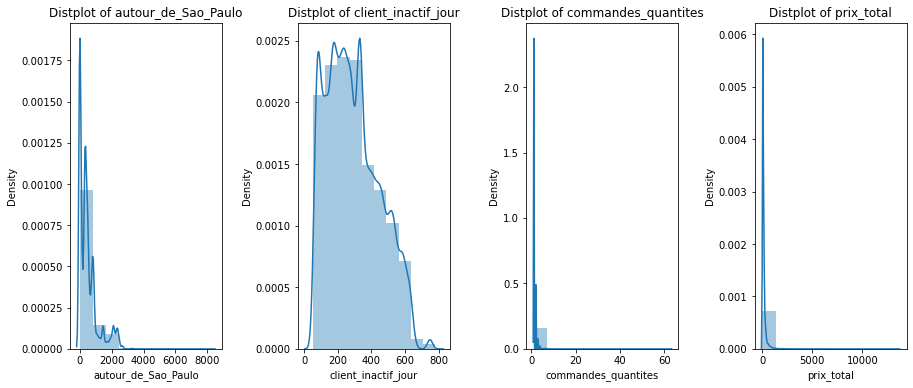

In [127]:
plt.figure(1, figsize=(15,6))
n=0
for x in col_observ:
    n+=1
    plt.subplot(1,4,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df_5[x], bins=10, kde=True)
    plt.title('Distplot of {}'.format(x))
    plt.savefig('images/valeurs_importantes.png')

#### Client_inactif_jour

In [128]:
df_5['client_inactif_jour'].describe()

count    96523.000000
mean       292.951804
std        152.760942
min         51.000000
25%        169.000000
50%        274.000000
75%        401.000000
max        780.000000
Name: client_inactif_jour, dtype: float64

In [129]:
# L'evolution d'e_commerce
df_5['ans'] = df_5['order_purchase_timestamp'].dt.year

In [130]:
df_5.groupby(by='ans').size()

ans
2016      290
2017    43463
2018    52770
dtype: int64

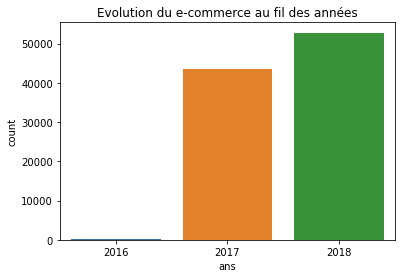

In [131]:
sns.countplot(df_5['ans'])
plt.title('Evolution du e-commerce au fil des années')
plt.savefig('images/annees.png')

#### Prix total

In [132]:
# Les 10 meilleurs produits
top_categorie  = df_5["product_category_name_english"].value_counts().sort_values(ascending=False)
top_categorie

home              16875
electronics       15139
health_beauty     14739
sports_leisure     9307
fashion            7941
appliances         7513
garden_pets        5166
arts               5004
office             4080
other              3853
auto               3850
construction       2107
food_drinks         949
Name: product_category_name_english, dtype: int64

#### Les produits pas chers sont généralement achetés plus souvent que les produits plus chers.

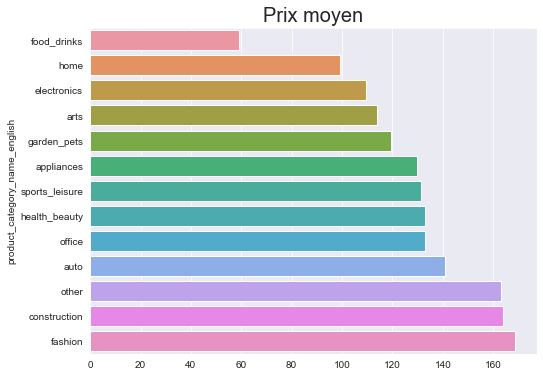

In [133]:
# Le prix moyen sur chaque catégorie de produit
prix_moyen = df_5.groupby("product_category_name_english")["price"].agg('mean').sort_values()

fig=plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.barplot(x=prix_moyen.values, y=prix_moyen.index)
plt.title('Prix moyen',fontsize=20)
plt.savefig('images/prix moyen.png')

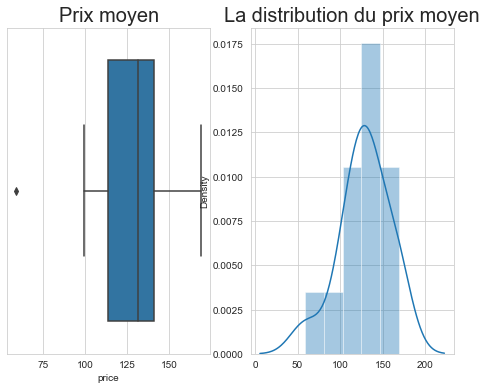

In [134]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
plt.subplot(121)
sns.boxplot(x=prix_moyen)
plt.title('Prix moyen',fontsize=20)
plt.subplot(122)
sns.distplot(x=prix_moyen)
plt.title('La distribution du prix moyen',fontsize=20)
plt.savefig('images/La distribution du prix moyen.png') 

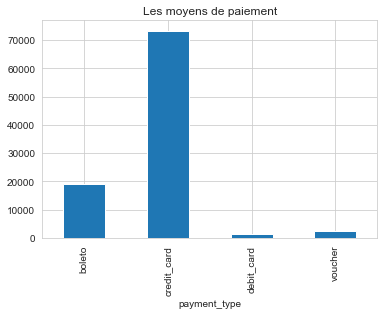

In [135]:
# Les moyens de paiement les plus populaires
df_5.groupby('payment_type')['ans'].count().plot(kind='bar')
plt.title('Les moyens de paiement')
plt.savefig('images/moyens de paiement.png')

#### Commandes quantites

In [136]:
# Achats en ligne par mois
df_5['mois'] = df_5['order_purchase_timestamp'].dt.month_name()
df_5['mois'].head()

0    September
1        April
2    September
3      January
4       August
Name: mois, dtype: object

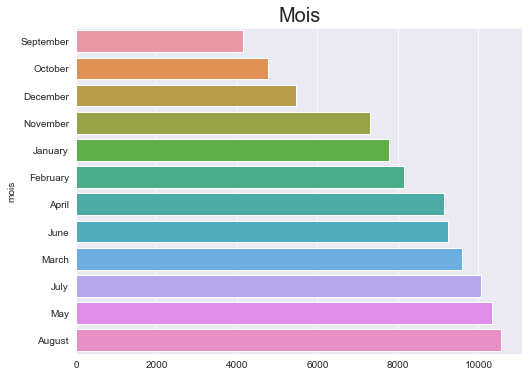

In [137]:
# Les clients commandent plus pendant et la veille des périodes estivale  
mois = df_5.groupby('mois').size().sort_values()
fig=plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.barplot(y=mois.index, x=mois.values)
plt.title('Mois',fontsize=20)
plt.savefig('images/mois.png')

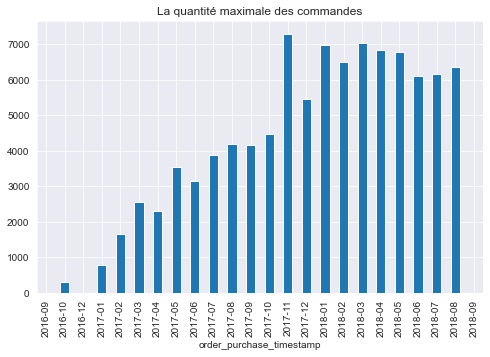

In [138]:
# La quantité maximale des commandes tomber en novembre 2017
df_5.groupby(df_5['order_purchase_timestamp'].dt.strftime('%Y-%m')).size().plot(kind = 'bar',figsize=(8,5))
plt.title('La quantité maximale des commandes')
plt.savefig('images/annees_mois.png')

#### Des clients, qui n'ont pas fait leurs achats le week-end, les font le premier jour de la semaine via Internet

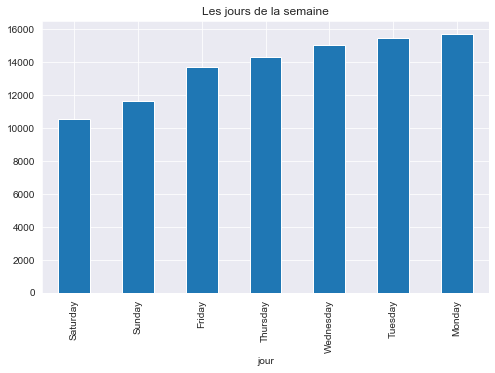

In [139]:
# Les jours de la semaine les plus favorables pour faire du shopping
df_5['jour'] = df_5['order_purchase_timestamp'].dt.day_name()
df_5.groupby('jour').size().sort_values().plot(
    kind = 'bar',
    figsize=(8,5))
plt.title('Les jours de la semaine')
plt.savefig('images/jours.png')

#### Autour de Sao_Paulo

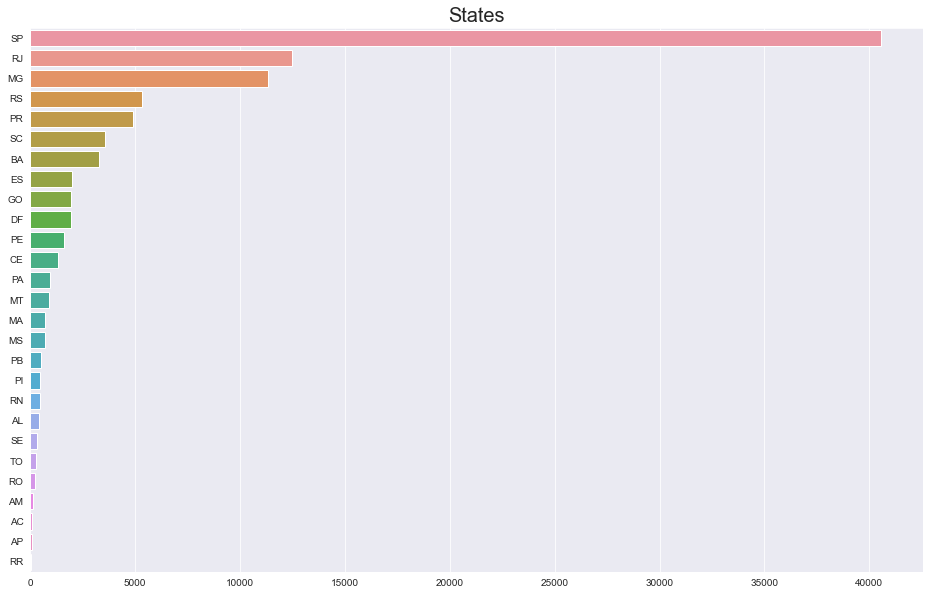

In [140]:
# Répartition des clients par l'États
top_states = df_5["customer_state"].value_counts()
plt.figure(figsize=(16,10))
sns.set_style("darkgrid")
sns.barplot(y=top_states.index, x=top_states.values)
plt.title('States',fontsize=20)
plt.savefig('images/states.png')

#### La corrélation entre le prix est du frais de port de l'article

In [141]:
round(df_5['freight_value'].corr(df_5['price']), 2)

0.42

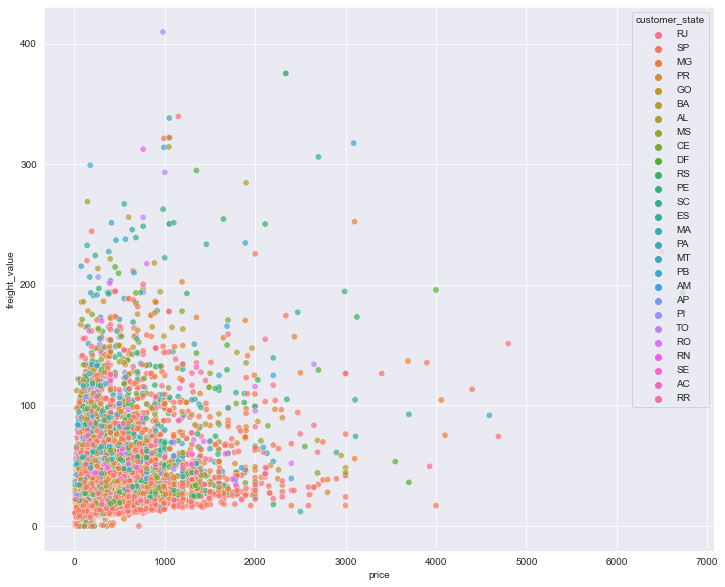

In [142]:
plt.figure(figsize=(12,10))
sns.set_style("darkgrid")
sns.scatterplot(x = 'price',y = 'freight_value',hue='customer_state',data=df_5, alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.savefig('images/prix_FDP.png')

#### La corrélation entre le lieu de livraison  est du frais de port de l'article

In [143]:
round(df_5['freight_value'].corr(df_5['autour_de_Sao_Paulo']), 2)

0.34

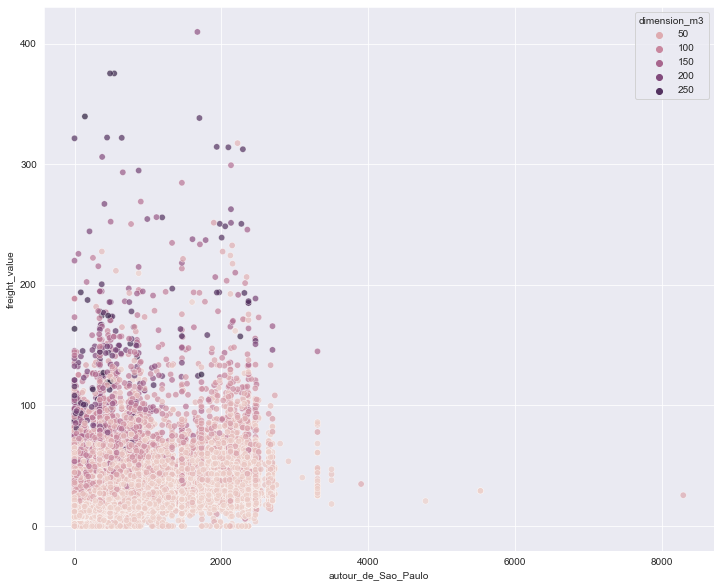

In [144]:
plt.figure(figsize=(12,10))
sns.set_style("darkgrid")
sns.scatterplot(x = 'autour_de_Sao_Paulo',y = 'freight_value',hue='dimension_m3',data=df_5, alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.savefig('images/lieu_FDP.png')

# 

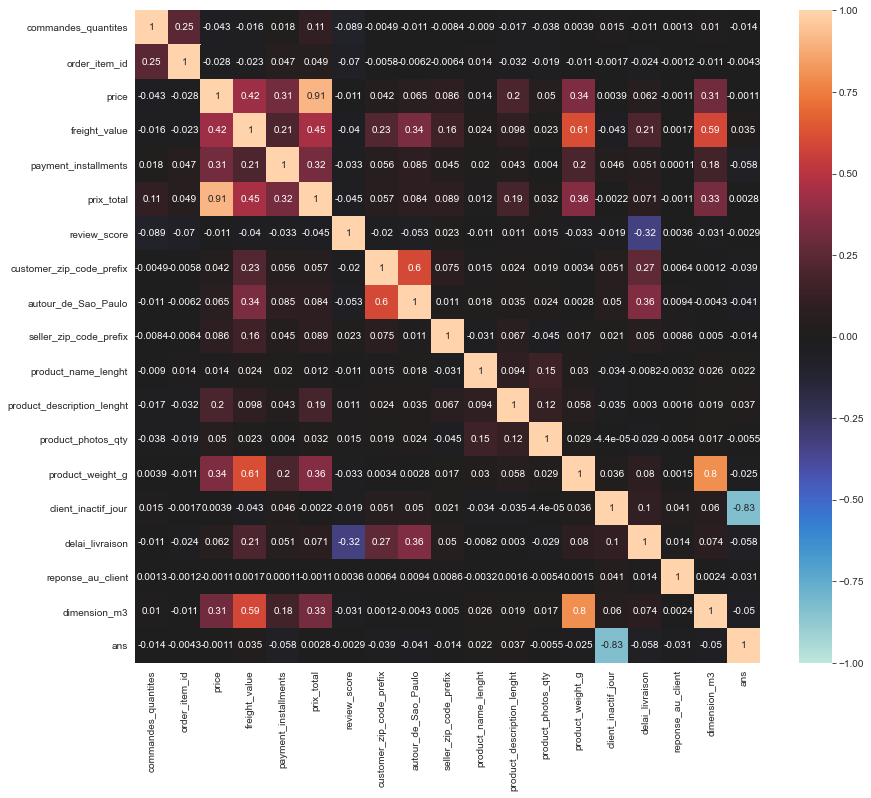

In [145]:
df_5_num = df_5.select_dtypes(['float','int'])
plt.figure(figsize=(14,12))
sns.heatmap(df_5.corr(),vmax=1.0,vmin=-1.0,center=0.0, annot=True)
plt.savefig('images/heatmap_corrélation_2.png')

In [146]:
threshold = 0.5
corr = df_5.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
10,price,prix_total,0.907310
8,dimension_m3,product_weight_g,0.801239
6,product_weight_g,freight_value,0.614791
4,customer_zip_code_prefix,autour_de_Sao_Paulo,0.601143
2,dimension_m3,freight_value,0.591023
0,ans,client_inactif_jour,-0.832812


In [147]:
valeurs_data =['order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date','shipping_limit_date']

In [148]:
# On n'a plus besoin des valeurs dtype = datetime64[ns], sauf 'order_purchase_timestamp'

df_5.drop(columns=valeurs_data,inplace = True)

In [149]:
df_5.dtypes

commandes_quantites                       int64
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_item_id                             int64
product_id                               object
seller_id                                object
price                                   float64
freight_value                           float64
payment_type                             object
payment_installments                      int64
prix_total                              float64
review_score                               int8
customer_unique_id                       object
customer_zip_code_prefix                  int64
autour_de_Sao_Paulo                     float64
customer_state                           object
seller_zip_code_prefix                    int64
seller_city                              object
seller_state                             object
product_name_lenght                     

In [150]:
# Observons des vendeurs 
df_5[['seller_id','seller_zip_code_prefix', 'seller_city','customer_zip_code_prefix','seller_state']]

,seller_id,seller_zip_code_prefix,seller_city,customer_zip_code_prefix,seller_state
0,48436dade18ac8b2bce089ec2a041202,27277,volta redonda,28013,SP
1,dd7ddc04e1b6c2c614352b383efe2d36,3471,sao paulo,15775,SP
2,36a968b544695394e4e9d7572688598f,11010,santos,15775,SP
3,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,35661,MG
4,9d7a1d34a5052409006425275ba1c2b4,14403,franca,12952,SP
...,...,...,...,...,...
96782,b8bc237ba3788b23da09c0f1f3a3288c,88303,itajai,65077,SC
96783,f3c38ab652836d21de61fb8314b69182,1206,sao paulo,81690,SP
96784,c3cfdc648177fdbbbb35635a37472c53,80610,curitiba,4039,PR
96785,2b3e4a2a3ea8e01938cabda2a3e5cc79,4733,sao paulo,13289,SP


In [151]:
# Le(les) marchandise qui vends les "meilleurs_vendeurs"
meilleurs_vendeurs = df_5.groupby(by='seller_id').size()[df_5.groupby(by='seller_id').size().values>=1000].index

In [152]:
# Ils n'y pas des vendeurs spécifiques qui pourraient être intéressants.Peut être pour calculer le frais de port
df_5[df_5['seller_id'].isin(meilleurs_vendeurs)]['product_category_name_english'].value_counts()

home              3189
fashion           2800
health_beauty     2170
garden_pets       1411
electronics       1269
other             1222
office             879
arts               295
appliances         180
sports_leisure     153
construction        63
auto                41
food_drinks          9
Name: product_category_name_english, dtype: int64

In [153]:
# On va les supprimer 
df_5.drop(columns=['seller_id','seller_zip_code_prefix', 'seller_city','seller_state'], inplace=True)

<AxesSubplot:ylabel='Density'>

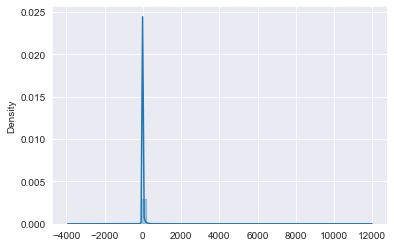

In [154]:
# La différence tend à zéro, donc on peut supprimer les composants de 'prix total'
diff = df_5['prix_total']-df_5['price']-df_5['freight_value']
sns.distplot(diff)

In [155]:
# Suppression 
df_5.drop(columns=['freight_value','price'], inplace=True)

In [156]:
# Les colonnes doublons ou inutiles 
colonne_a_supprimer = ['customer_id','order_status','order_item_id','product_id',
                       'customer_state','customer_zip_code_prefix',
                       'product_name_lenght', 'product_description_lenght']

In [157]:
df_5.drop(columns=colonne_a_supprimer,inplace=True)

In [158]:
df_6=df_5.copy()

In [159]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96523 entries, 0 to 96786
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   commandes_quantites            96523 non-null  int64         
 1   order_purchase_timestamp       96523 non-null  datetime64[ns]
 2   payment_type                   96523 non-null  object        
 3   payment_installments           96523 non-null  int64         
 4   prix_total                     96523 non-null  float64       
 5   review_score                   96523 non-null  int8          
 6   customer_unique_id             96523 non-null  object        
 7   autour_de_Sao_Paulo            96523 non-null  float64       
 8   product_photos_qty             96523 non-null  float64       
 9   product_weight_g               96523 non-null  float64       
 10  product_category_name_english  96523 non-null  object        
 11  client_inactif_

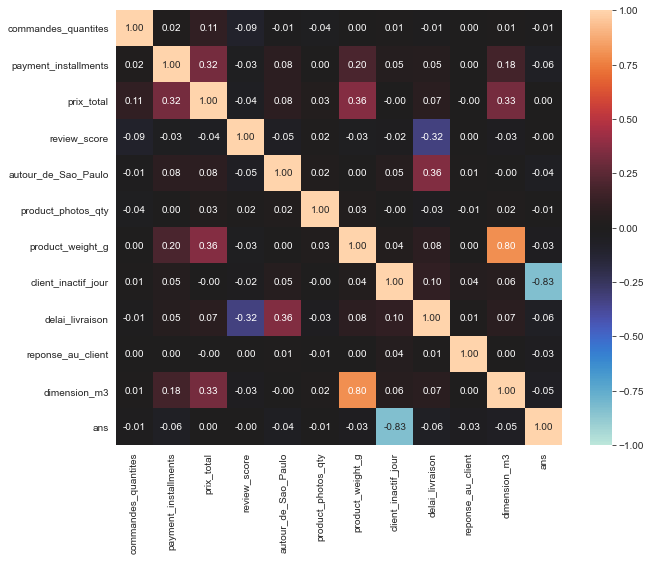

In [160]:
df_6_num = df_6.select_dtypes(['float','int'])
plt.figure(figsize=(10,8))
sns.heatmap(df_6.corr(),vmax=1.0,vmin=-1.0,center=0.0, annot=True,fmt='.2f' )
plt.savefig('images/heatmap_corrélation_3.png')

In [161]:
# Il y a une forte corrélation entre 'dimension_m3' et 'product_weight_g'
df_4_poids_dim.head() 

,customer_city,freight_value,dimension_m3,product_weight_g
0,580.1,13.29,3.528,650.0
1,577.1,19.93,60.000,30000.0
2,577.1,11.85,2.304,180.0
3,462.7,17.87,14.157,3050.0
4,50.5,12.79,2.400,200.0


In [162]:
# Peuimporte laquelle on laisse ( ou supprime)
print(round(df_4['freight_value'].corr(df_4['dimension_m3']), 2))
print(round(df_4['freight_value'].corr(df_4['product_weight_g']), 2))

0.59
0.61


In [163]:
df_6.drop(columns='product_weight_g', inplace=True)

In [164]:
# Transformation
df_6 = pd.get_dummies(df_6, columns=['product_category_name_english','payment_type'])

In [165]:
df_6.rename(columns={'product_category_name_english_appliances':'appliances',
                     'product_category_name_english_arts':'arts',
                     'product_category_name_english_auto':'auto',
                     'product_category_name_english_construction':'construction',
                     'product_category_name_english_electronics':'electronics',
                     'product_category_name_english_fashion':'fashion',
                     'product_category_name_english_food_drinks':'food_drinks',
                     'product_category_name_english_garden_pets':'garden_pets',
                     'product_category_name_english_health_beauty':'health_beauty',
                     'product_category_name_english_home':'home',
                     'product_category_name_english_office':'office',
                     'product_category_name_english_other':'other',
                     'product_category_name_english_sports_leisure':'sports_leisure'}, inplace=True)


In [166]:
df_6

,commandes_quantites,order_purchase_timestamp,payment_installments,prix_total,review_score,customer_unique_id,autour_de_Sao_Paulo,product_photos_qty,client_inactif_jour,delai_livraison,reponse_au_client,dimension_m3,ans,mois,jour,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,1,2017-09-13 08:59:02,2,72.19,5,871766c5855e863f6eccc05f988b23cb,580.1,4.0,406,7,1.0,3.528,2017,September,Wednesday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,1,2017-04-26 10:53:06,3,259.83,4,eb28e67c4c0b83846050ddfb8a35d051,577.1,2.0,401,16,2.0,60.000,2017,April,Wednesday,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1,2017-09-18 16:12:04,1,24.73,5,eb28e67c4c0b83846050ddfb8a35d051,577.1,1.0,401,7,3.0,2.304,2017,September,Monday,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1,2018-01-14 14:33:31,5,216.87,5,3818d81c6709e39d06b2738a8d3a2474,462.7,2.0,283,7,1.0,14.157,2018,January,Sunday,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1,2018-08-08 10:00:35,2,25.78,4,af861d436cfc08b2c2ddefd0ba074622,50.5,1.0,77,6,1.0,2.400,2018,August,Wednesday,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96782,1,2018-04-23 13:57:06,1,343.40,5,0c9aeda10a71f369396d0c04dce13a64,2352.6,3.0,184,17,3.0,53.400,2018,April,Monday,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
96783,1,2018-07-14 10:26:46,1,386.53,5,0da9fe112eae0c74d3ba1fe16de0988b,339.8,1.0,102,9,1.0,44.460,2018,July,Saturday,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
96784,1,2017-10-23 17:07:56,3,116.85,5,cd79b407828f02fdbba457111c38e4c4,0.0,1.0,366,4,1.0,9.576,2017,October,Monday,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
96785,1,2017-08-14 23:02:59,3,64.71,5,eb803377c9315b564bdedad672039306,69.3,1.0,436,1,1.0,8.000,2017,August,Monday,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [167]:
# Grâce à  RFM nous trouverons des clients de plus fidèle à très fragiles
col_observ[1:]

['client_inactif_jour', 'commandes_quantites', 'prix_total']

In [168]:
# Divisons en 4 segments à l'aide du quantile 
quantile = df_6[col_observ[1:]].quantile(q=[0.25,0.5,0.75])
quantile = quantile.to_dict()

In [169]:
# Fonction pour créer R, F et M

def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
def FMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1    

In [170]:
df_6['R'] = df_6['client_inactif_jour'].apply(RScoring,args = ('client_inactif_jour',quantile))
df_6['F'] = df_6['commandes_quantites'].apply(FMScoring,args = ('commandes_quantites',quantile))
df_6['M'] = df_6['prix_total'].apply(FMScoring,args = ('prix_total',quantile))

In [171]:
# Calculons et ajoutons la colonne de valeur RFMGroup affichant le score en combinant de RFM
df_6['RFMGroup'] = df_6.R.map(str) + df_6.F.map(str) + df_6.M.map(str)

In [172]:
# RFMScore affiche la somme totale des valeurs RFMGroup
df_6['Score'] = df_6[['R','F','M']].sum(axis=1)

In [173]:
# Attribuer un niveau de fidélité à chaque client
Niveau_de_fidelite = ['Platine', 'Or', 'Argent', 'Bronze']
Score_cuts = pd.qcut(df_6.Score,q = 4,labels=Niveau_de_fidelite)
df_6['RFM_niveau_de_fidelite'] = Score_cuts.values
df_6.head()

,commandes_quantites,order_purchase_timestamp,payment_installments,prix_total,review_score,customer_unique_id,autour_de_Sao_Paulo,product_photos_qty,client_inactif_jour,delai_livraison,reponse_au_client,dimension_m3,ans,mois,jour,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,R,F,M,RFMGroup,Score,RFM_niveau_de_fidelite
0,1,2017-09-13 08:59:02,2,72.19,5,871766c5855e863f6eccc05f988b23cb,580.1,4.0,406,7,1.0,3.528,2017,September,Wednesday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,4,4,3,443,11,Bronze
1,1,2017-04-26 10:53:06,3,259.83,4,eb28e67c4c0b83846050ddfb8a35d051,577.1,2.0,401,16,2.0,60.000,2017,April,Wednesday,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,4,1,341,8,Or
2,1,2017-09-18 16:12:04,1,24.73,5,eb28e67c4c0b83846050ddfb8a35d051,577.1,1.0,401,7,3.0,2.304,2017,September,Monday,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3,4,4,344,11,Bronze
3,1,2018-01-14 14:33:31,5,216.87,5,3818d81c6709e39d06b2738a8d3a2474,462.7,2.0,283,7,1.0,14.157,2018,January,Sunday,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3,4,1,341,8,Or
4,1,2018-08-08 10:00:35,2,25.78,4,af861d436cfc08b2c2ddefd0ba074622,50.5,1.0,77,6,1.0,2.400,2018,August,Wednesday,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,4,4,144,9,Or


In [174]:
df_6.dtypes

commandes_quantites                  int64
order_purchase_timestamp    datetime64[ns]
payment_installments                 int64
prix_total                         float64
review_score                          int8
customer_unique_id                  object
autour_de_Sao_Paulo                float64
product_photos_qty                 float64
client_inactif_jour                  int32
delai_livraison                      int32
reponse_au_client                  float64
dimension_m3                       float64
ans                                  int64
mois                                object
jour                                object
appliances                           uint8
arts                                 uint8
auto                                 uint8
construction                         uint8
electronics                          uint8
fashion                              uint8
food_drinks                          uint8
garden_pets                          uint8
health_beau

In [175]:
oe = OrdinalEncoder()

In [176]:
# On va encoder les 2 variables
df_6[['jour','mois']] = oe.fit_transform(df_6[['jour','mois']])

In [177]:
# Changement de type
df_6['RFMGroup'] = df_6['RFMGroup'].astype('int')

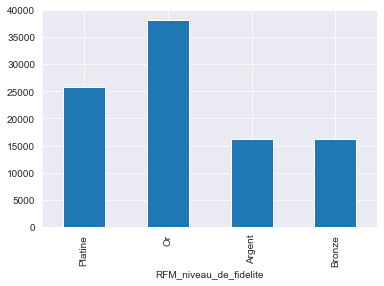

In [178]:
# Distribution ces 4 types de clients
df_6.groupby(by='RFM_niveau_de_fidelite').size().plot(kind='bar')
plt.savefig('images/Distribution_4_types_clients.png')

In [179]:
Client_platine = df_6[df_6['RFM_niveau_de_fidelite'] == 'Platine'].set_index('customer_unique_id')
Client_or = df_6[df_6['RFM_niveau_de_fidelite'] == 'Or'].set_index('customer_unique_id')
Client_argent = df_6[df_6['RFM_niveau_de_fidelite'] == 'Argent'].set_index('customer_unique_id')
Client_bronze = df_6[df_6['RFM_niveau_de_fidelite'] == 'Bronze'].set_index('customer_unique_id')

In [180]:
col_observ

['autour_de_Sao_Paulo',
 'client_inactif_jour',
 'commandes_quantites',
 'prix_total']

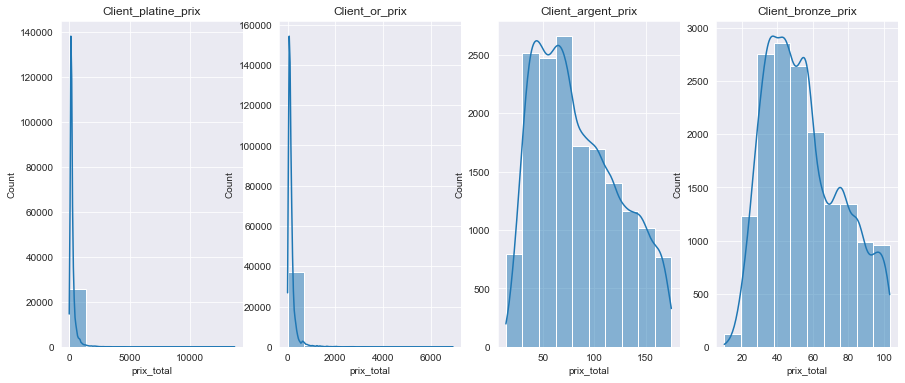

In [181]:
# les clients de "platine et or" qui payent plus
plt.figure(1, figsize=(15,6))

plt.subplot(1,4,1)
plt.title('Client_platine_prix')
sns.histplot(Client_platine['prix_total'], bins=10, kde=True)
plt.subplot(1,4,2)
plt.title('Client_or_prix')
sns.histplot(Client_or['prix_total'], bins=10, kde=True)
plt.subplot(1,4,3)
plt.title('Client_argent_prix')
sns.histplot(Client_argent['prix_total'], bins=10, kde=True)
plt.subplot(1,4,4)
plt.title('Client_bronze_prix')
sns.histplot(Client_bronze['prix_total'], bins=10, kde=True)

plt.savefig('images/client_prix.png');

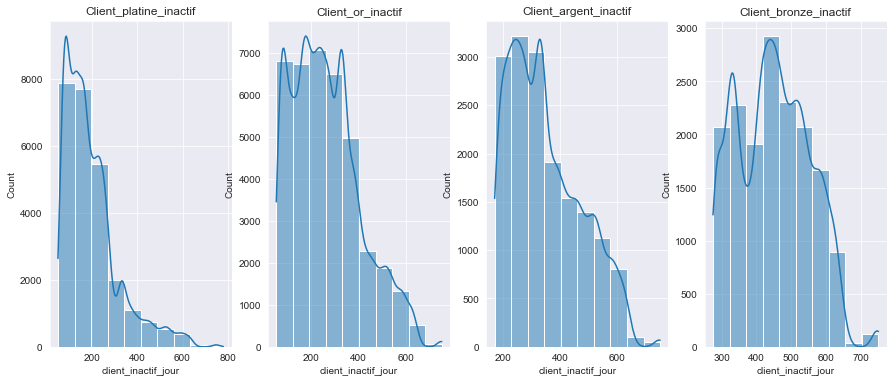

In [182]:
# Plus de clients inactifs en "platine" environ 8000, mais plus de 600 jour au moyen dans les "bronze"
plt.figure(1, figsize=(15,6))

plt.subplot(1,4,1)
plt.title('Client_platine_inactif')
sns.histplot(Client_platine['client_inactif_jour'], bins=10, kde=True)
plt.subplot(1,4,2)
plt.title('Client_or_inactif')
sns.histplot(Client_or['client_inactif_jour'], bins=10, kde=True)
plt.subplot(1,4,3)
plt.title('Client_argent_inactif')
sns.histplot(Client_argent['client_inactif_jour'], bins=10, kde=True)
plt.subplot(1,4,4)
plt.title('Client_bronze_inactif')
sns.histplot(Client_bronze['client_inactif_jour'], bins=10, kde=True)

plt.savefig('images/client_inactif.png');

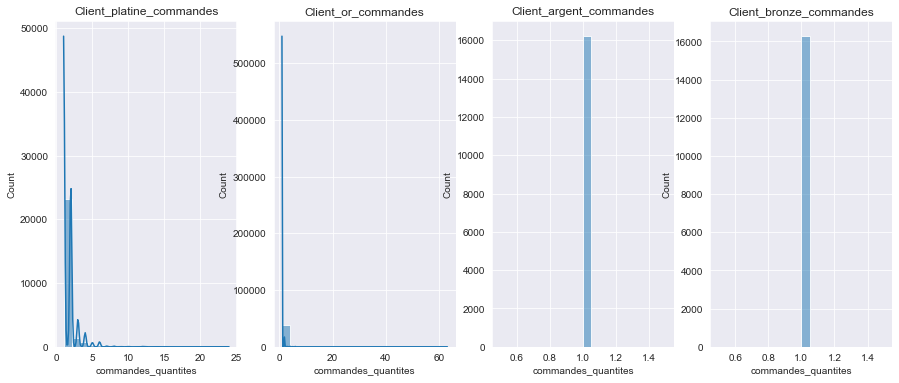

In [183]:
# les clients "argent" et "bronze" passés  une seule commande
plt.figure(1, figsize=(15,6))

plt.subplot(1,4,1)
plt.title('Client_platine_commandes')
sns.histplot(Client_platine['commandes_quantites'], bins=20, kde=True)
plt.subplot(1,4,2)
plt.title('Client_or_commandes')
sns.histplot(Client_or['commandes_quantites'], bins=20, kde=True)
plt.subplot(1,4,3)
plt.title('Client_argent_commandes')
sns.histplot(Client_argent['commandes_quantites'], bins=20, kde=True)
plt.subplot(1,4,4)
plt.title('Client_bronze_commandes')
sns.histplot(Client_bronze['commandes_quantites'], bins=20, kde=True)

plt.savefig('images/client_commande.png');

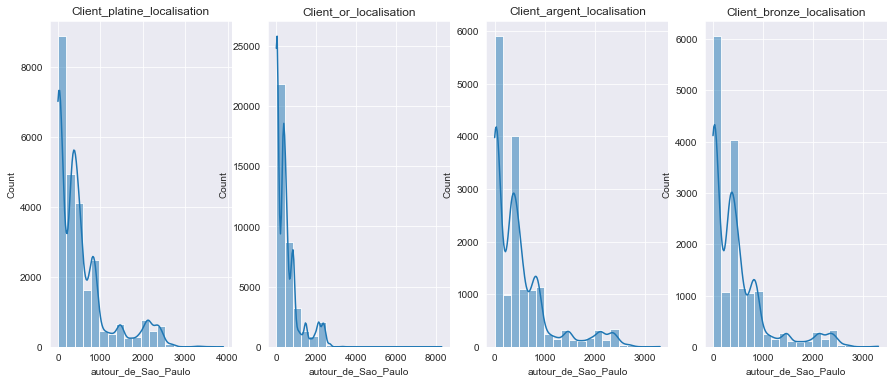

In [184]:
# Les clients sont répartis sur environ 1000 km autour de São Paulo
plt.figure(1, figsize=(15,6))

plt.subplot(1,4,1)
plt.title('Client_platine_localisation')
sns.histplot(Client_platine['autour_de_Sao_Paulo'], bins=20, kde=True)
plt.subplot(1,4,2)
plt.title('Client_or_localisation')
sns.histplot(Client_or['autour_de_Sao_Paulo'], bins=20, kde=True)
plt.subplot(1,4,3)
plt.title('Client_argent_localisation')
sns.histplot(Client_argent['autour_de_Sao_Paulo'], bins=20, kde=True)
plt.subplot(1,4,4)
plt.title('Client_bronze_localisation')
sns.histplot(Client_bronze['autour_de_Sao_Paulo'], bins=20, kde=True)

plt.savefig('images/client_local.png');

In [185]:
marchandises  = ['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']

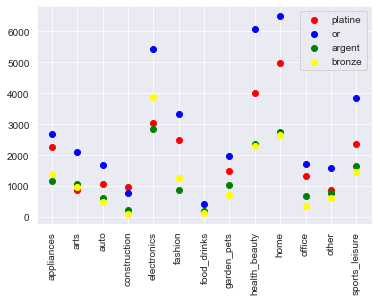

In [186]:
n=4
datasets = [Client_platine,Client_or,Client_argent,Client_bronze]
couleurs = ['red','blue','green','yellow']
label =['platine','or','argent','bronze']

#     datasets[i]['couleur'] = couleurs[i]
printed = False
for m in marchandises:
    for i in range(n):
        plt.scatter(x = m,y = datasets[i][datasets[i][m].values !=0][m].sum(),label=label[i], c=couleurs[i])
        plt.xticks(rotation=90)
        if printed== False:
            plt.legend()
    printed = True    
plt.savefig('images/distribution_produits.png')        

In [187]:
# on va chercher des erreurs (anomalies) ou des nombres atypiques dans les colonnes suivants:
erreurs = ['commandes_quantites','client_inactif_jour', 'delai_livraison',
       'reponse_au_client', 'dimension_m3', 'prix_total','autour_de_Sao_Paulo']

In [188]:
model_forest = IsolationForest(contamination=0.001,random_state=42)

In [189]:
model_forest.fit(df_6[erreurs])

IsolationForest(contamination=0.001, random_state=42)

In [190]:
predict = model_forest.predict(df_6[erreurs])
predict

array([1, 1, 1, ..., 1, 1, 1])

In [191]:
outliers = predict==-1
outliers

array([False, False, False, ..., False, False, False])

In [192]:
df_6[erreurs][outliers].shape

(97, 7)

In [193]:
# Pas de valeurs aberrants 
df_6[erreurs][outliers].describe().T

,count,mean,std,min,25%,50%,75%,max
commandes_quantites,97.0,3.257732,3.827745,1.000,1.000,2.00,5.000,20.00
client_inactif_jour,97.0,365.515464,176.105858,56.000,235.000,335.00,503.000,750.00
delai_livraison,97.0,29.453608,25.425144,1.000,13.000,26.00,39.000,187.00
reponse_au_client,97.0,18.247423,38.889006,1.000,1.000,3.00,12.000,188.00
dimension_m3,97.0,149.655784,88.461710,2.992,74.088,144.00,244.608,294.00
prix_total,97.0,1351.649588,741.019931,9.340,873.280,1247.36,1837.160,3195.73
autour_de_Sao_Paulo,97.0,1296.702062,917.228070,0.000,391.800,1442.70,2219.300,2694.80


In [194]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96523 entries, 0 to 96786
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   commandes_quantites       96523 non-null  int64         
 1   order_purchase_timestamp  96523 non-null  datetime64[ns]
 2   payment_installments      96523 non-null  int64         
 3   prix_total                96523 non-null  float64       
 4   review_score              96523 non-null  int8          
 5   customer_unique_id        96523 non-null  object        
 6   autour_de_Sao_Paulo       96523 non-null  float64       
 7   product_photos_qty        96523 non-null  float64       
 8   client_inactif_jour       96523 non-null  int32         
 9   delai_livraison           96523 non-null  int32         
 10  reponse_au_client         96523 non-null  float64       
 11  dimension_m3              96523 non-null  float64       
 12  ans               

In [195]:
# on va supprimer les variables intermédiaires 
df_6.drop(columns=['R','F','M','RFMGroup','Score'],inplace=True)

In [196]:
# Encoding
df_6 = pd.get_dummies(df_6, columns=['RFM_niveau_de_fidelite'])

In [197]:
# Observons les medians les features à standardisée pour PCA
variables_a_stand  = ['commandes_quantites', 'payment_installments',
       'prix_total', 'review_score', 'autour_de_Sao_Paulo',
       'product_photos_qty', 'client_inactif_jour', 'delai_livraison',
       'reponse_au_client', 'dimension_m3', 'ans', 'mois', 'jour']

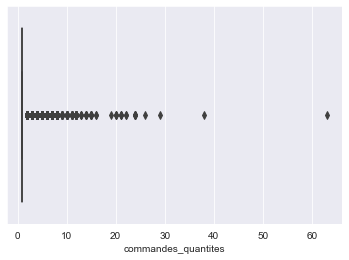

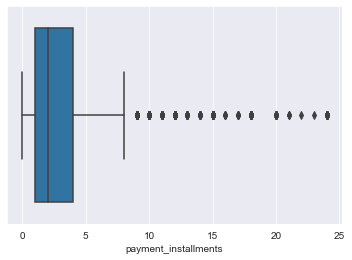

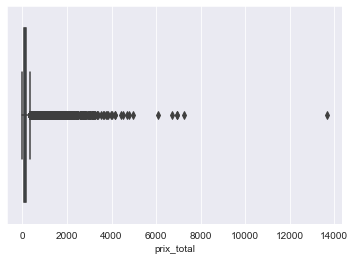

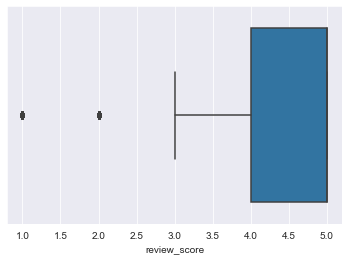

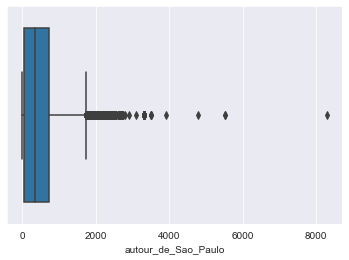

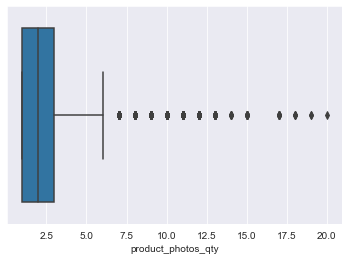

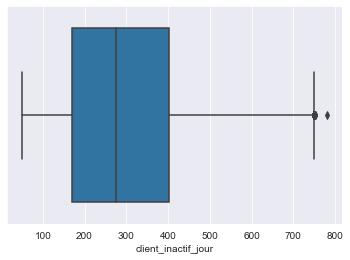

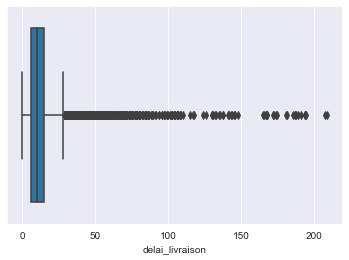

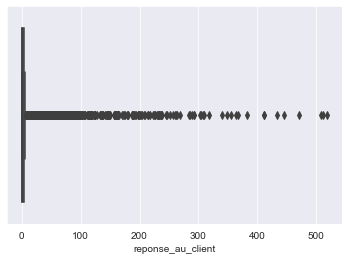

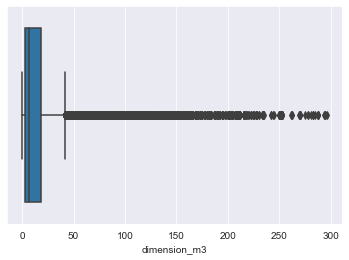

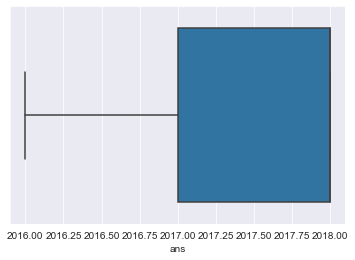

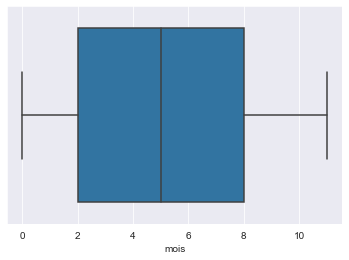

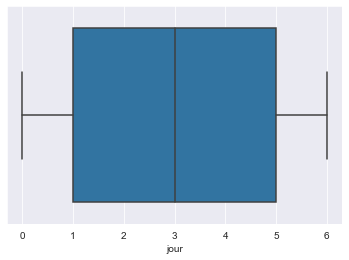

In [198]:
for col in variables_a_stand:
    plt.figure()
    sns.boxplot(df_6[col])

In [199]:
df_6 = df_6[df_6['commandes_quantites']<=16]
df_6 = df_6[df_6['payment_installments']<=df_6['payment_installments'].quantile(0.75)+1.5*\
                     (df_6['payment_installments'].quantile(0.75)-df_6['payment_installments'].quantile(0.25))]
df_6 = df_6[df_6['prix_total']<=5000]
df_6 = df_6[df_6['autour_de_Sao_Paulo']<=4000]
df_6 = df_6[df_6['product_photos_qty']<=df_6['product_photos_qty'].quantile(0.75)+1.5*\
                     (df_6['product_photos_qty'].quantile(0.75)-df_6['product_photos_qty'].quantile(0.25))]
df_6 = df_6[df_6['client_inactif_jour']<=df_6['client_inactif_jour'].quantile(0.75)+1.5*\
                     (df_6['client_inactif_jour'].quantile(0.75)-df_6['client_inactif_jour'].quantile(0.25))]
df_6 = df_6[df_6['delai_livraison']<=150]
df_6 = df_6.drop(columns=['reponse_au_client'])
df_6 = df_6[df_6['dimension_m3']<=250]


In [200]:
df_6.set_index("customer_unique_id").to_csv("data/nettoyage_de_donnees.csv")